In [1]:
format(Sys.time(), "%a %b %d %X %Y")

[1] "Sun Aug 03 05:46:45 PM 2025"

In [2]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,656842,35.1,1439205,76.9,1439205,76.9
Vcells,1224845,9.4,8388608,64.0,1924961,14.7


In [3]:
# Paso 1: Instalación de paquetes necesarios
if (!require("lightgbm")) install.packages("lightgbm")
if (!require("mlrMBO")) install.packages("mlrMBO")
if (!require("data.table")) install.packages("data.table")

library(lightgbm)
library(mlrMBO)
library(data.table)
library(parallel)
library(smoof)
library(mlr)
library(ggplot2)

Loading required package: lightgbm

Loading required package: mlrMBO

Loading required package: mlr

Loading required package: ParamHelpers

Loading required package: smoof

Loading required package: checkmate

Loading required package: data.table



In [4]:
# Se convierte el dataset iris en una tarea binaria
# La clase "versicolor" será 1 y las demás serán 0
iris_bin <- as.data.table(iris)
iris_bin[, target := ifelse(Species == "versicolor", 1L, 0L)]
iris_bin[, Species := NULL]

In [5]:
# Separamos 70% para entrenamiento y 30% para validación
set.seed(123)
idx_train <- sample(1:nrow(iris_bin), 0.7 * nrow(iris_bin))
train <- iris_bin[idx_train]
test <- iris_bin[-idx_train]

In [6]:
dtrain <- lgb.Dataset(data = data.matrix(train[, !"target", with=FALSE]),
                      label = train$target)
nrow(dtrain)
ncol(dtrain)

[1] 105

[1] 4

In [7]:
param_base <- list(objective = "binary",
                   metric = "auc",
                   verbosity = -1,
                   feature_pre_filter = FALSE)

In [8]:
# Paso 6: Definición del espacio de búsqueda para Bayesian Optimization
ps <- makeParamSet(
  makeNumericParam("learning_rate", lower = 0.01, upper = 0.2),
  makeIntegerParam("num_leaves", lower = 10L, upper = 100L),
  makeIntegerParam("min_data_in_leaf", lower = 5L, upper = 50L)
)


In [9]:
# Paso 7: Definición de la función objetivo
# Se maximiza el AUC promedio de un cross-validation con 3 folds
obj_fun <- makeSingleObjectiveFunction(
  fn = function(x) {
    x <- as.list(x)
    param <- modifyList(param_base, x)
    cv <- lgb.cv(params = param,
                 data = dtrain,
                 nfold = 3,
                 nrounds = 100,
                 early_stopping_rounds = 10,
                 verbose = -1)
    return(max(unlist(cv$record_evals$valid$auc$eval)))
  },
  par.set = ps,
  minimize = FALSE
)

In [10]:
ctrl <- makeMBOControl()
ctrl <- setMBOControlTermination(ctrl, iters = 100)  # número de iteraciones
ctrl <- setMBOControlInfill(ctrl, crit = makeMBOInfillCritEI())

In [11]:
surrogate <- makeLearner("regr.km", predict.type = "se")

In [12]:
run <- mbo(obj_fun, learner = surrogate, control = ctrl)

Computing y column(s) for design. Not provided.

[mbo] 0: learning_rate=0.136; num_leaves=78; min_data_in_leaf=27 : y = 0.895 : 0.2 secs : initdesign

[mbo] 0: learning_rate=0.0523; num_leaves=66; min_data_in_leaf=41 : y = 0.5 : 0.1 secs : initdesign

[mbo] 0: learning_rate=0.143; num_leaves=59; min_data_in_leaf=34 : y = 0.526 : 0.0 secs : initdesign

[mbo] 0: learning_rate=0.173; num_leaves=28; min_data_in_leaf=21 : y = 0.976 : 0.0 secs : initdesign

[mbo] 0: learning_rate=0.0866; num_leaves=35; min_data_in_leaf=50 : y = 0.5 : 0.0 secs : initdesign

[mbo] 0: learning_rate=0.0598; num_leaves=99; min_data_in_leaf=37 : y = 0.5 : 0.0 secs : initdesign

[mbo] 0: learning_rate=0.0922; num_leaves=89; min_data_in_leaf=12 : y = 0.991 : 0.1 secs : initdesign

[mbo] 0: learning_rate=0.119; num_leaves=21; min_data_in_leaf=17 : y = 0.981 : 0.1 secs : initdesign

[mbo] 0: learning_rate=0.0149; num_leaves=17; min_data_in_leaf=6 : y = 0.925 : 0.0 secs : initdesign

[mbo] 0: learning_rate=0.158; num_l


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3634012 164 88 
  - best initial criterion value(s) :  10.02864 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -10.029  |proj g|=      0.26477
At iterate     1  f =      -10.119  |proj g|=       0.24401
At iterate     2  f =      -10.362  |proj g|=       0.15226
At iterate     3  f =      -10.436  |proj g|=      0.029741
At iterate     4  f =      -10.442  |proj g|=      0.024884
At iterate     5  f =      -10.445  |proj g|=      0.024797
At iterate     6  f =      -10.457  |proj g|=      0.037573
At iterate     7  f =      -10.484  |proj g|=      0.077847
At iterate     8  f =      -10.557  |proj g|=       0.14035
At iterate     9

[mbo] 1: learning_rate=0.165; num_leaves=100; min_data_in_leaf=20 : y = 0.976 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3634012 166 88 
  - best initial criterion value(s) :  9.11954 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -9.1195  |proj g|=       0.4839
At iterate     1  f =      -9.8787  |proj g|=       0.44828
At iterate     2  f =      -11.732  |proj g|=       0.18208
At iterate     3  f =      -11.855  |proj g|=      0.025107
At iterate     4  f =       -11.86  |proj g|=      0.025144
At iterate     5  f =      -11.881  |proj g|=      0.045852
At iterate     6  f =      -11.935  |proj g|=       0.11351
At iterate     7  f =       -12.06  |proj g|=       0.20601
At iterate     8  f =       -12.34  |proj g|=       0.29718
At iterate     9 

[mbo] 2: learning_rate=0.02; num_leaves=44; min_data_in_leaf=13 : y = 0.945 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3634012 166 88 
  - best initial criterion value(s) :  6.255134 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -6.2551  |proj g|=      0.15747
At iterate     1  f =      -7.0221  |proj g|=        0.1802
At iterate     2  f =      -10.027  |proj g|=       0.12102
At iterate     3  f =      -10.073  |proj g|=        0.1003
At iterate     4  f =      -10.198  |proj g|=       0.10422
At iterate     5  f =      -10.378  |proj g|=      0.094056
At iterate     6  f =      -11.051  |proj g|=       0.13053
At iterate     7  f =      -12.237  |proj g|=        0.1548
At iterate     8  f =      -13.514  |proj g|=       0.32616
At iterate     9

[mbo] 3: learning_rate=0.173; num_leaves=100; min_data_in_leaf=7 : y = 0.943 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3634012 166 88 
  - best initial criterion value(s) :  13.57893 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -13.579  |proj g|=       0.4565
At iterate     1  f =       -14.13  |proj g|=       0.39659
At iterate     2  f =      -14.741  |proj g|=       0.26562
At iterate     3  f =      -15.019  |proj g|=      0.070027
At iterate     4  f =      -15.039  |proj g|=      0.030233
At iterate     5  f =      -15.043  |proj g|=        0.0301
At iterate     6  f =      -15.056  |proj g|=      0.029659
At iterate     7  f =      -15.088  |proj g|=      0.069851
At iterate     8  f =      -15.164  |proj g|=       0.13729
At iterate     9

[mbo] 4: learning_rate=0.15; num_leaves=80; min_data_in_leaf=15 : y = 0.986 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3634012 166 88 
  - best initial criterion value(s) :  13.73118 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -13.731  |proj g|=      0.89945
At iterate     1  f =      -14.768  |proj g|=       0.63453
At iterate     2  f =      -15.573  |proj g|=      0.076461
At iterate     3  f =      -15.592  |proj g|=      0.075928
At iterate     4  f =      -15.762  |proj g|=       0.12761
At iterate     5  f =      -16.001  |proj g|=        0.2223
At iterate     6  f =      -16.529  |proj g|=       0.32642
At iterate     7  f =      -17.352  |proj g|=       0.36982
At iterate     8  f =      -18.723  |proj g|=       0.30448
At iterate     9

[mbo] 5: learning_rate=0.129; num_leaves=59; min_data_in_leaf=11 : y = 0.982 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3634012 166 88 
  - best initial criterion value(s) :  18.73577 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -18.736  |proj g|=      0.67367
At iterate     1  f =      -20.638  |proj g|=       0.57394
At iterate     2  f =      -21.098  |proj g|=       0.50316
At iterate     3  f =      -22.051  |proj g|=       0.03833
At iterate     4  f =      -22.054  |proj g|=      0.018077
At iterate     5  f =      -22.056  |proj g|=      0.016896
At iterate     6  f =      -22.059  |proj g|=       0.01684
At iterate     7  f =      -22.068  |proj g|=      0.043021
At iterate     8  f =      -22.089  |proj g|=      0.085295
At iterate     9

[mbo] 6: learning_rate=0.2; num_leaves=10; min_data_in_leaf=17 : y = 0.963 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3702375 180 88 
  - best initial criterion value(s) :  22.50139 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -22.501  |proj g|=      0.12971
At iterate     1  f =      -23.495  |proj g|=       0.10639
At iterate     2  f =       -23.51  |proj g|=      0.075039
At iterate     3  f =      -23.527  |proj g|=      0.027217
At iterate     4  f =      -23.532  |proj g|=      0.027077
At iterate     5  f =      -23.564  |proj g|=      0.058404
At iterate     6  f =      -23.645  |proj g|=       0.13951
At iterate     7  f =      -23.817  |proj g|=       0.23337
At iterate     8  f =      -24.154  |proj g|=       0.31337
At iterate     9

[mbo] 7: learning_rate=0.0858; num_leaves=88; min_data_in_leaf=22 : y = 0.978 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3702375 180 88 
  - best initial criterion value(s) :  19.27231 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -19.272  |proj g|=      0.74364
At iterate     1  f =      -19.885  |proj g|=       0.74745
At iterate     2  f =      -26.435  |proj g|=       0.12503
At iterate     3  f =      -26.464  |proj g|=      0.023902
At iterate     4  f =      -26.493  |proj g|=      0.044578
At iterate     5  f =      -26.647  |proj g|=        0.1814
At iterate     6  f =       -26.95  |proj g|=       0.32209
At iterate     7  f =      -27.205  |proj g|=       0.22001
At iterate     8  f =      -27.285  |proj g|=      0.036785
At iterate     9

[mbo] 8: learning_rate=0.154; num_leaves=100; min_data_in_leaf=12 : y = 0.978 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3702375 180 88 
  - best initial criterion value(s) :  28.83502 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -28.835  |proj g|=      0.44033
At iterate     1  f =      -28.846  |proj g|=       0.45567
At iterate     2  f =      -28.875  |proj g|=       0.45544
At iterate     3  f =      -29.113  |proj g|=       0.37805
At iterate     4  f =      -29.346  |proj g|=       0.21607
At iterate     5  f =      -29.562  |proj g|=       0.04984
At iterate     6  f =      -29.576  |proj g|=      0.035782
At iterate     7  f =      -29.576  |proj g|=      0.016929
At iterate     8  f =      -29.576  |proj g|=      0.016922
At iterate     9

[mbo] 9: learning_rate=0.01; num_leaves=100; min_data_in_leaf=5 : y = 0.926 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  29.88368 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -29.884  |proj g|=      0.58792
At iterate     1  f =      -30.254  |proj g|=       0.38352
At iterate     2  f =      -30.524  |proj g|=      0.036408
At iterate     3  f =      -30.529  |proj g|=      0.028808
At iterate     4  f =      -30.535  |proj g|=      0.028621
At iterate     5  f =      -30.552  |proj g|=      0.058827
At iterate     6  f =      -30.588  |proj g|=       0.11345
At iterate     7  f =      -30.666  |proj g|=       0.17846
At iterate     8  f =      -30.823  |proj g|=       0.23789
At iterate     9

[mbo] 10: learning_rate=0.117; num_leaves=63; min_data_in_leaf=19 : y = 0.987 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  32.12162 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -32.122  |proj g|=      0.83181
At iterate     1  f =      -33.506  |proj g|=       0.52986
At iterate     2  f =      -34.071  |proj g|=       0.39606
At iterate     3  f =      -34.699  |proj g|=       0.35381
At iterate     4  f =      -34.751  |proj g|=      0.092345
At iterate     5  f =      -34.769  |proj g|=      0.035628
At iterate     6  f =      -34.772  |proj g|=      0.023169
At iterate     7  f =      -34.775  |proj g|=       0.19248
At iterate     8  f =      -34.818  |proj g|=       0.33881
At iterate     9

[mbo] 11: learning_rate=0.113; num_leaves=63; min_data_in_leaf=14 : y = 0.981 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  35.94711 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -35.947  |proj g|=      0.50386
At iterate     1  f =      -36.567  |proj g|=       0.26925
At iterate     2  f =      -36.669  |proj g|=       0.37999
At iterate     3  f =      -36.929  |proj g|=       0.34442
At iterate     4  f =      -36.953  |proj g|=      0.048055
At iterate     5  f =      -36.954  |proj g|=     0.0072554
At iterate     6  f =      -36.954  |proj g|=      0.024103
At iterate     7  f =      -36.954  |proj g|=       0.04976
At iterate     8  f =      -36.956  |proj g|=      0.051781
At iterate     9

[mbo] 12: learning_rate=0.2; num_leaves=76; min_data_in_leaf=22 : y = 0.977 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  38.07406 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -38.074  |proj g|=       1.1437
At iterate     1  f =      -39.319  |proj g|=       0.52473
At iterate     2  f =      -39.577  |proj g|=        0.3952
At iterate     3  f =      -39.875  |proj g|=       0.25573
At iterate     4  f =      -40.029  |proj g|=      0.060166
At iterate     5  f =      -40.046  |proj g|=       0.15045
At iterate     6  f =      -40.047  |proj g|=      0.040965
At iterate     7  f =      -40.047  |proj g|=     0.0053157
At iterate     8  f =      -40.047  |proj g|=     0.0053273
At iterate     9

[mbo] 13: learning_rate=0.2; num_leaves=10; min_data_in_leaf=8 : y = 0.963 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  36.47611 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -36.476  |proj g|=      0.44399
At iterate     1  f =      -38.578  |proj g|=       0.28374
At iterate     2  f =      -38.645  |proj g|=       0.21732
At iterate     3  f =      -38.834  |proj g|=       0.14178
At iterate     4  f =      -38.935  |proj g|=       0.13771
At iterate     5  f =      -39.311  |proj g|=        0.2833
At iterate     6  f =      -39.945  |proj g|=       0.43073
At iterate     7  f =       -41.09  |proj g|=       0.48694
At iterate     8  f =      -42.142  |proj g|=       0.32875
At iterate     9

[mbo] 14: learning_rate=0.0648; num_leaves=100; min_data_in_leaf=17 : y = 0.987 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  41.70538 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -41.705  |proj g|=      0.87748
At iterate     1  f =      -43.969  |proj g|=       0.48502
At iterate     2  f =      -44.257  |proj g|=       0.42449
At iterate     3  f =      -45.144  |proj g|=       0.37999
At iterate     4  f =      -45.348  |proj g|=        0.3425
At iterate     5  f =      -45.455  |proj g|=       0.25439
At iterate     6  f =      -45.455  |proj g|=      0.075152
At iterate     7  f =      -45.455  |proj g|=     0.0028088
At iterate     8  f =      -45.455  |proj g|=     0.0034244
At iterate     9

[mbo] 15: learning_rate=0.0547; num_leaves=100; min_data_in_leaf=10 : y = 0.977 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  43.4501 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       -43.45  |proj g|=       2.0145
At iterate     1  f =      -47.366  |proj g|=       0.90448
At iterate     2  f =       -48.41  |proj g|=       0.18539
At iterate     3  f =       -48.47  |proj g|=      0.041403
At iterate     4  f =      -48.475  |proj g|=      0.041544
At iterate     5  f =      -48.476  |proj g|=      0.041518
At iterate     6  f =      -48.484  |proj g|=      0.049194
At iterate     7  f =        -48.5  |proj g|=       0.08977
At iterate     8  f =      -48.542  |proj g|=       0.14952
At iterate     9 

[mbo] 16: learning_rate=0.109; num_leaves=86; min_data_in_leaf=18 : y = 0.993 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  48.24157 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -48.242  |proj g|=      0.89874
At iterate     1  f =       -52.49  |proj g|=       0.55562
At iterate     2  f =      -52.776  |proj g|=       0.45163
At iterate     3  f =      -53.195  |proj g|=       0.15788
At iterate     4  f =      -53.235  |proj g|=      0.034991
At iterate     5  f =      -53.236  |proj g|=      0.034688
At iterate     6  f =      -53.237  |proj g|=      0.034598
At iterate     7  f =      -53.239  |proj g|=      0.034207
At iterate     8  f =      -53.243  |proj g|=      0.047587
At iterate     9

[mbo] 17: learning_rate=0.2; num_leaves=36; min_data_in_leaf=5 : y = 0.951 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  53.08737 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -53.087  |proj g|=      0.79776
At iterate     1  f =      -54.289  |proj g|=       0.59678
At iterate     2  f =      -54.822  |proj g|=       0.47485
At iterate     3  f =      -55.634  |proj g|=       0.37999
At iterate     4  f =      -55.659  |proj g|=       0.36902
At iterate     5  f =      -55.667  |proj g|=      0.025467
At iterate     6  f =      -55.668  |proj g|=      0.020101
At iterate     7  f =      -55.669  |proj g|=      0.020017
At iterate     8  f =      -55.677  |proj g|=       0.13237
At iterate     9

[mbo] 18: learning_rate=0.159; num_leaves=27; min_data_in_leaf=12 : y = 0.981 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  50.60443 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -50.604  |proj g|=       1.2037
At iterate     1  f =      -53.297  |proj g|=        1.1318
At iterate     2  f =      -56.976  |proj g|=       0.95414
At iterate     3  f =      -57.798  |proj g|=       0.85497
At iterate     4  f =      -59.785  |proj g|=      0.048215
At iterate     5  f =      -59.789  |proj g|=      0.021964
At iterate     6  f =       -59.79  |proj g|=      0.022373
At iterate     7  f =      -59.791  |proj g|=      0.022544
At iterate     8  f =      -59.794  |proj g|=      0.027567
At iterate     9

[mbo] 19: learning_rate=0.104; num_leaves=87; min_data_in_leaf=17 : y = 0.978 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  44.89989 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=        -44.9  |proj g|=       1.1788
At iterate     1  f =      -46.284  |proj g|=        1.1939
At iterate     2  f =      -51.403  |proj g|=       0.30374
At iterate     3  f =      -51.439  |proj g|=      0.029761
At iterate     4  f =      -51.439  |proj g|=     0.0035572
At iterate     5  f =      -51.439  |proj g|=     0.0035409
At iterate     6  f =      -51.439  |proj g|=     0.0035225
At iterate     7  f =      -51.439  |proj g|=     0.0063532
At iterate     8  f =       -51.44  |proj g|=      0.012656
At iterate     9

[mbo] 20: learning_rate=0.01; num_leaves=100; min_data_in_leaf=19 : y = 0.91 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  35.57525 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -35.575  |proj g|=      0.68678
At iterate     1  f =      -35.844  |proj g|=       0.87798
At iterate     2  f =      -35.852  |proj g|=       0.85948
At iterate     3  f =      -35.855  |proj g|=       0.85337
At iterate     4  f =       -35.86  |proj g|=         0.844
At iterate     5  f =      -35.876  |proj g|=       0.82857
At iterate     6  f =      -35.916  |proj g|=       0.80499
At iterate     7  f =      -36.025  |proj g|=       0.76924
At iterate     8  f =      -36.327  |proj g|=       0.71846
At iterate     9

[mbo] 21: learning_rate=0.149; num_leaves=100; min_data_in_leaf=23 : y = 0.97 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  45.50949 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -45.509  |proj g|=      0.30078
At iterate     1  f =      -48.938  |proj g|=       0.48188
At iterate     2  f =      -49.125  |proj g|=       0.46512
At iterate     3  f =      -49.168  |proj g|=       0.44239
At iterate     4  f =      -49.171  |proj g|=       0.44716
At iterate     5  f =      -49.272  |proj g|=       0.32354
At iterate     6  f =       -49.37  |proj g|=       0.22723
At iterate     7  f =      -49.371  |proj g|=      0.059797
At iterate     8  f =      -49.371  |proj g|=      0.050538
At iterate     9

[mbo] 22: learning_rate=0.0773; num_leaves=100; min_data_in_leaf=19 : y = 0.971 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  44.66003 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       -44.66  |proj g|=       1.6636
At iterate     1  f =      -45.856  |proj g|=        0.2144
At iterate     2  f =      -45.935  |proj g|=        1.0205
At iterate     3  f =      -46.109  |proj g|=       0.87397
At iterate     4  f =      -46.844  |proj g|=       0.19448
At iterate     5  f =      -46.958  |proj g|=       0.51294
At iterate     6  f =      -47.021  |proj g|=       0.33075
At iterate     7  f =      -47.045  |proj g|=        0.1294
At iterate     8  f =      -47.048  |proj g|=       0.13159
At iterate     9

[mbo] 23: learning_rate=0.0541; num_leaves=100; min_data_in_leaf=15 : y = 0.945 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  48.75579 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -48.756  |proj g|=       1.4002
At iterate     1  f =      -49.213  |proj g|=         1.827
At iterate     2  f =      -49.575  |proj g|=        1.6131
At iterate     3  f =      -49.735  |proj g|=        1.3052
At iterate     4  f =      -49.843  |proj g|=        1.1872
At iterate     5  f =      -50.235  |proj g|=       0.21769
At iterate     6  f =      -50.246  |proj g|=       0.16641
At iterate     7  f =      -50.247  |proj g|=      0.045742
At iterate     8  f =      -50.247  |proj g|=      0.045742
At iterate     9

[mbo] 24: learning_rate=0.0645; num_leaves=37; min_data_in_leaf=18 : y = 0.963 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  52.1855 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -52.186  |proj g|=      0.17998
At iterate     1  f =      -52.242  |proj g|=       0.17004
At iterate     2  f =      -52.244  |proj g|=       0.18275
At iterate     3  f =      -52.244  |proj g|=       0.17503
At iterate     4  f =      -52.244  |proj g|=       0.16833
At iterate     5  f =      -52.245  |proj g|=        0.1687
At iterate     6  f =      -52.246  |proj g|=       0.16897
At iterate     7  f =      -52.248  |proj g|=       0.16866
At iterate     8  f =      -52.251  |proj g|=       0.16707
At iterate     9 

[mbo] 25: learning_rate=0.152; num_leaves=55; min_data_in_leaf=18 : y = 0.973 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  51.70958 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       -51.71  |proj g|=       3.7462
At iterate     1  f =       -52.41  |proj g|=         2.845
At iterate     2  f =      -52.767  |proj g|=        1.1814
At iterate     3  f =      -53.437  |proj g|=        0.2965
At iterate     4  f =      -53.448  |proj g|=       0.24216
At iterate     5  f =      -53.449  |proj g|=      0.035744
At iterate     6  f =      -53.449  |proj g|=      0.021016
At iterate     7  f =      -53.449  |proj g|=      0.021018
At iterate     8  f =      -53.449  |proj g|=      0.062683
At iterate     9

[mbo] 26: learning_rate=0.182; num_leaves=10; min_data_in_leaf=15 : y = 0.988 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  54.04843 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -54.048  |proj g|=       2.7777
At iterate     1  f =      -55.667  |proj g|=        1.3414
At iterate     2  f =      -55.975  |proj g|=       0.50777
At iterate     3  f =      -56.009  |proj g|=       0.22866
At iterate     4  f =      -56.011  |proj g|=       0.22729
At iterate     5  f =      -56.015  |proj g|=         0.225
At iterate     6  f =      -56.022  |proj g|=       0.15931
At iterate     7  f =      -56.026  |proj g|=       0.16263
At iterate     8  f =      -56.026  |proj g|=       0.21782
At iterate     9

[mbo] 27: learning_rate=0.124; num_leaves=60; min_data_in_leaf=22 : y = 0.969 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  56.2146 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -56.215  |proj g|=      0.58647
At iterate     1  f =       -56.39  |proj g|=       0.37999
At iterate     2  f =      -56.872  |proj g|=       0.57806
At iterate     3  f =      -56.912  |proj g|=       0.35294
At iterate     4  f =       -56.93  |proj g|=      0.094236
At iterate     5  f =       -56.93  |proj g|=      0.017791
At iterate     6  f =       -56.93  |proj g|=       0.01551
At iterate     7  f =       -56.93  |proj g|=      0.018182
At iterate     8  f =       -56.93  |proj g|=       0.05537
At iterate     9 

[mbo] 28: learning_rate=0.102; num_leaves=10; min_data_in_leaf=8 : y = 0.982 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  50.24609 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -50.246  |proj g|=      0.62714
At iterate     1  f =      -51.128  |proj g|=       0.54647
At iterate     2  f =      -51.128  |proj g|=       0.54835
At iterate     3  f =      -51.131  |proj g|=       0.55185
At iterate     4  f =      -51.137  |proj g|=       0.55787
At iterate     5  f =      -51.154  |proj g|=       0.56636
At iterate     6  f =      -51.197  |proj g|=       0.57791
At iterate     7  f =      -51.307  |proj g|=       0.58937
At iterate     8  f =      -51.575  |proj g|=       0.58619
At iterate     9

[mbo] 29: learning_rate=0.0742; num_leaves=100; min_data_in_leaf=8 : y = 0.95 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  43.99147 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -43.991  |proj g|=       3.0548
At iterate     1  f =      -53.846  |proj g|=          3.32
ys=-8.075e-01  -gs= 9.364e+00, BFGS update SKIPPED
At iterate     2  f =      -61.269  |proj g|=       0.78416
At iterate     3  f =      -61.352  |proj g|=       0.75198
At iterate     4  f =      -61.437  |proj g|=        0.1158
At iterate     5  f =      -61.437  |proj g|=     0.0082624
At iterate     6  f =      -61.437  |proj g|=      0.019659
At iterate     7  f =      -61.437  |proj g|=      0.034973
At iterate     8  f =    

[mbo] 30: learning_rate=0.0631; num_leaves=10; min_data_in_leaf=11 : y = 0.982 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  48.07599 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -48.076  |proj g|=       2.0953
At iterate     1  f =      -54.382  |proj g|=       0.48118
At iterate     2  f =      -54.426  |proj g|=       0.39306
At iterate     3  f =      -55.566  |proj g|=       0.31005
At iterate     4  f =      -55.718  |proj g|=       0.30756
At iterate     5  f =      -56.536  |proj g|=        1.0231
At iterate     6  f =      -57.774  |proj g|=        2.1327
At iterate     7  f =      -60.804  |proj g|=       0.22368
At iterate     8  f =      -62.257  |proj g|=       0.64188
At iterate     9

[mbo] 31: learning_rate=0.184; num_leaves=100; min_data_in_leaf=14 : y = 0.989 : 0.3 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  63.45992 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       -63.46  |proj g|=       2.8387
At iterate     1  f =      -66.215  |proj g|=         1.232
At iterate     2  f =      -66.468  |proj g|=        1.2265
At iterate     3  f =      -66.693  |proj g|=       0.37999
At iterate     4  f =      -66.702  |proj g|=      0.040061
At iterate     5  f =      -66.702  |proj g|=      0.021853
At iterate     6  f =      -66.702  |proj g|=      0.027892
At iterate     7  f =      -66.704  |proj g|=       0.13559
At iterate     8  f =      -66.709  |proj g|=         0.298
At iterate     9

[mbo] 32: learning_rate=0.0388; num_leaves=100; min_data_in_leaf=25 : y = 0.889 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  53.54402 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -53.544  |proj g|=       7.9603
At iterate     1  f =      -66.058  |proj g|=        2.4003
At iterate     2  f =      -67.631  |proj g|=        1.0749
At iterate     3  f =      -68.281  |proj g|=       0.47423
At iterate     4  f =      -68.631  |proj g|=       0.12422
At iterate     5  f =      -68.633  |proj g|=       0.17017
At iterate     6  f =      -68.633  |proj g|=      0.025451
At iterate     7  f =      -68.633  |proj g|=      0.014157
At iterate     8  f =      -68.633  |proj g|=      0.082497
At iterate     9

[mbo] 33: learning_rate=0.144; num_leaves=66; min_data_in_leaf=13 : y = 0.964 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  57.59723 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -57.597  |proj g|=      0.98361
At iterate     1  f =      -57.968  |proj g|=         1.047
At iterate     2  f =      -58.037  |proj g|=        1.0326
At iterate     3  f =      -58.479  |proj g|=       0.94247
At iterate     4  f =      -59.551  |proj g|=       0.83853
At iterate     5  f =      -61.976  |proj g|=       0.33942
At iterate     6  f =      -63.231  |proj g|=        0.4199
At iterate     7  f =      -64.626  |proj g|=        0.3225
At iterate     8  f =      -64.725  |proj g|=       0.31873
At iterate     9

[mbo] 34: learning_rate=0.107; num_leaves=15; min_data_in_leaf=11 : y = 0.958 : 0.3 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  61.34173 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -61.342  |proj g|=      0.26532
At iterate     1  f =      -63.619  |proj g|=        2.1623
At iterate     2  f =      -64.229  |proj g|=        1.9169
At iterate     3  f =      -65.546  |proj g|=       0.37999
At iterate     4  f =      -65.559  |proj g|=        0.0591
At iterate     5  f =       -65.56  |proj g|=      0.087795
At iterate     6  f =       -65.56  |proj g|=     0.0052028
At iterate     7  f =      -65.561  |proj g|=      0.013778
At iterate     8  f =      -65.564  |proj g|=      0.015204
At iterate     9

[mbo] 35: learning_rate=0.181; num_leaves=100; min_data_in_leaf=18 : y = 0.974 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  70.2471 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -70.247  |proj g|=        3.476
At iterate     1  f =      -71.048  |proj g|=        2.3936
At iterate     2  f =      -71.805  |proj g|=       0.67922
At iterate     3  f =      -71.836  |proj g|=       0.31592
At iterate     4  f =      -71.844  |proj g|=      0.065692
At iterate     5  f =      -71.844  |proj g|=      0.035609
At iterate     6  f =      -71.844  |proj g|=      0.035631
At iterate     7  f =      -71.844  |proj g|=      0.085651
At iterate     8  f =      -71.844  |proj g|=      0.085893
At iterate     9 

[mbo] 36: learning_rate=0.01; num_leaves=60; min_data_in_leaf=11 : y = 0.931 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  67.95182 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -67.952  |proj g|=      0.79359
At iterate     1  f =      -68.065  |proj g|=       0.75971
At iterate     2  f =      -68.321  |proj g|=       0.53285
At iterate     3  f =      -68.336  |proj g|=       0.57651
At iterate     4  f =      -68.423  |proj g|=       0.59153
At iterate     5  f =      -69.012  |proj g|=       0.53366
At iterate     6  f =      -69.307  |proj g|=       0.25884
At iterate     7  f =      -69.408  |proj g|=       0.16528
At iterate     8  f =      -69.428  |proj g|=      0.067722
At iterate     9

[mbo] 37: learning_rate=0.123; num_leaves=100; min_data_in_leaf=17 : y = 0.984 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  57.66047 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       -57.66  |proj g|=       2.8785
At iterate     1  f =      -70.061  |proj g|=      0.082123
At iterate     2  f =      -70.096  |proj g|=      0.074466
At iterate     3  f =      -70.098  |proj g|=      0.086128
At iterate     4  f =      -70.101  |proj g|=       0.30667
At iterate     5  f =      -70.107  |proj g|=       0.30802
At iterate     6  f =      -70.112  |proj g|=       0.30873
At iterate     7  f =      -70.115  |proj g|=       0.30878
At iterate     8  f =      -70.116  |proj g|=      0.081225
At iterate     9

[mbo] 38: learning_rate=0.112; num_leaves=12; min_data_in_leaf=5 : y = 0.908 : 0.4 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  71.28153 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -71.282  |proj g|=      0.77728
At iterate     1  f =      -71.686  |proj g|=        1.1766
At iterate     2  f =      -71.941  |proj g|=       0.61075
At iterate     3  f =      -72.021  |proj g|=       0.20249
At iterate     4  f =      -72.027  |proj g|=       0.19445
At iterate     5  f =      -73.157  |proj g|=       0.25354
At iterate     6  f =      -74.374  |proj g|=       0.86385
At iterate     7  f =      -74.397  |proj g|=       0.96209
At iterate     8  f =       -74.89  |proj g|=       0.18796
At iterate     9

[mbo] 39: learning_rate=0.0712; num_leaves=10; min_data_in_leaf=14 : y = 0.939 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  63.80385 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -63.804  |proj g|=      0.74252
At iterate     1  f =      -68.315  |proj g|=       0.99185
At iterate     2  f =      -68.455  |proj g|=        1.0146
At iterate     3  f =      -68.507  |proj g|=        1.0237
At iterate     4  f =      -68.523  |proj g|=        1.0243
At iterate     5  f =      -68.563  |proj g|=        1.0214
At iterate     6  f =      -68.676  |proj g|=         1.004
At iterate     7  f =      -68.945  |proj g|=       0.94488
At iterate     8  f =      -69.665  |proj g|=       0.76045
At iterate     9

[mbo] 40: learning_rate=0.185; num_leaves=52; min_data_in_leaf=11 : y = 0.975 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  61.16134 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -61.161  |proj g|=       2.5969
At iterate     1  f =      -75.696  |proj g|=       0.74308
At iterate     2  f =      -75.812  |proj g|=        0.6834
At iterate     3  f =      -76.118  |proj g|=       0.31171
At iterate     4  f =      -76.154  |proj g|=       0.31098
At iterate     5  f =       -76.18  |proj g|=       0.30505
At iterate     6  f =      -76.289  |proj g|=       0.11537
At iterate     7  f =      -76.298  |proj g|=      0.076736
At iterate     8  f =      -76.298  |proj g|=      0.076408
At iterate     9

[mbo] 41: learning_rate=0.154; num_leaves=10; min_data_in_leaf=8 : y = 0.922 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  73.27467 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -73.275  |proj g|=       3.1287
At iterate     1  f =      -74.642  |proj g|=       0.87049
At iterate     2  f =       -74.95  |proj g|=        1.1523
At iterate     3  f =      -75.154  |proj g|=        1.2393
At iterate     4  f =      -75.386  |proj g|=        1.0605
At iterate     5  f =      -75.714  |proj g|=       0.48466
At iterate     6  f =      -75.737  |proj g|=       0.29209
At iterate     7  f =      -75.803  |proj g|=       0.15386
At iterate     8  f =      -75.807  |proj g|=       0.15229
At iterate     9

[mbo] 42: learning_rate=0.0687; num_leaves=46; min_data_in_leaf=9 : y = 0.927 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  67.02191 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -67.022  |proj g|=        8.614
At iterate     1  f =      -74.525  |proj g|=        1.9039
At iterate     2  f =      -75.944  |proj g|=       0.98904
At iterate     3  f =      -76.144  |proj g|=       0.51742
At iterate     4  f =      -76.205  |proj g|=        0.1453
At iterate     5  f =      -76.206  |proj g|=      0.058397
At iterate     6  f =      -76.206  |proj g|=      0.006329
At iterate     7  f =      -76.206  |proj g|=     0.0063141
At iterate     8  f =      -76.206  |proj g|=     0.0085167
At iterate     9

[mbo] 43: learning_rate=0.188; num_leaves=31; min_data_in_leaf=15 : y = 0.993 : 0.3 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  53.55115 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -53.551  |proj g|=      0.70024
At iterate     1  f =      -56.012  |proj g|=        0.8458
At iterate     2  f =      -61.925  |proj g|=       0.86864
At iterate     3  f =      -62.325  |proj g|=       0.78062
At iterate     4  f =      -62.339  |proj g|=       0.75147
At iterate     5  f =      -62.367  |proj g|=       0.76344
At iterate     6  f =      -62.436  |proj g|=       0.77875
At iterate     7  f =      -62.683  |proj g|=       0.81877
At iterate     8  f =      -71.802  |proj g|=        1.3299
At iterate     9

[mbo] 44: learning_rate=0.0544; num_leaves=100; min_data_in_leaf=12 : y = 0.99 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  80.66486 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -80.665  |proj g|=       1.4319
At iterate     1  f =      -81.318  |proj g|=        1.0818
At iterate     2  f =      -82.904  |proj g|=       0.59018
At iterate     3  f =      -82.939  |proj g|=       0.85897
At iterate     4  f =      -83.061  |proj g|=       0.66863
At iterate     5  f =      -83.534  |proj g|=      0.079223
At iterate     6  f =      -83.538  |proj g|=       0.11817
At iterate     7  f =      -83.549  |proj g|=       0.33123
At iterate     8  f =       -83.55  |proj g|=      0.032599
At iterate     9

[mbo] 45: learning_rate=0.11; num_leaves=100; min_data_in_leaf=9 : y = 0.971 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  74.52695 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -74.527  |proj g|=       2.0305
At iterate     1  f =      -82.295  |proj g|=       0.32589
At iterate     2  f =      -82.681  |proj g|=       0.41615
At iterate     3  f =      -82.776  |proj g|=       0.31705
At iterate     4  f =      -82.948  |proj g|=       0.31158
At iterate     5  f =      -82.984  |proj g|=        0.3098
At iterate     6  f =      -82.996  |proj g|=        0.3075
At iterate     7  f =      -82.997  |proj g|=       0.29168
At iterate     8  f =      -82.997  |proj g|=      0.064694
At iterate     9

[mbo] 46: learning_rate=0.0582; num_leaves=82; min_data_in_leaf=18 : y = 0.99 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  78.02836 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -78.028  |proj g|=       1.2799
At iterate     1  f =      -80.424  |proj g|=        1.6175
At iterate     2  f =      -80.512  |proj g|=        1.6264
At iterate     3  f =      -81.182  |proj g|=          1.57
At iterate     4  f =      -82.416  |proj g|=        1.1469
At iterate     5  f =      -83.993  |proj g|=       0.35625
At iterate     6  f =      -85.062  |proj g|=       0.72471
At iterate     7  f =      -85.661  |proj g|=       0.32228
At iterate     8  f =      -85.671  |proj g|=       0.32144
At iterate     9

[mbo] 47: learning_rate=0.108; num_leaves=100; min_data_in_leaf=11 : y = 0.987 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  85.34088 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -85.341  |proj g|=       1.5608
At iterate     1  f =      -86.327  |proj g|=        1.4189
At iterate     2  f =       -86.38  |proj g|=        1.4486
At iterate     3  f =      -86.389  |proj g|=        1.4617
At iterate     4  f =      -86.405  |proj g|=        1.4691
At iterate     5  f =      -86.455  |proj g|=        1.4695
At iterate     6  f =      -86.688  |proj g|=        1.4223
At iterate     7  f =      -87.106  |proj g|=        1.2456
At iterate     8  f =      -87.994  |proj g|=       0.60832
At iterate     9

[mbo] 48: learning_rate=0.11; num_leaves=100; min_data_in_leaf=23 : y = 0.97 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799926 180 90 
  - best initial criterion value(s) :  87.114 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -87.114  |proj g|=       2.8501
At iterate     1  f =       -90.74  |proj g|=        1.2028
At iterate     2  f =      -90.998  |proj g|=       0.62603
At iterate     3  f =      -91.423  |proj g|=       0.27419
At iterate     4  f =      -91.563  |proj g|=       0.11808
At iterate     5  f =      -91.566  |proj g|=       0.26082
At iterate     6  f =      -91.567  |proj g|=      0.074048
At iterate     7  f =      -91.567  |proj g|=       0.11927
At iterate     8  f =      -91.567  |proj g|=       0.11933
At iterate     9  

[mbo] 49: learning_rate=0.2; num_leaves=25; min_data_in_leaf=12 : y = 0.977 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  83.97659 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -83.977  |proj g|=       7.4199
At iterate     1  f =       -90.21  |proj g|=         1.022
At iterate     2  f =      -92.495  |proj g|=       0.15434
At iterate     3  f =      -93.104  |proj g|=        3.1489
At iterate     4  f =      -93.657  |proj g|=       0.95839
At iterate     5  f =      -94.375  |proj g|=       0.96741
At iterate     6  f =      -94.536  |proj g|=        1.1767
At iterate     7  f =      -94.733  |proj g|=       0.39997
At iterate     8  f =      -94.767  |proj g|=       0.22215
At iterate     9

[mbo] 50: learning_rate=0.19; num_leaves=10; min_data_in_leaf=25 : y = 0.95 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  92.45941 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -92.459  |proj g|=      0.32025
At iterate     1  f =      -93.878  |proj g|=        1.0842
At iterate     2  f =      -93.884  |proj g|=        1.0343
At iterate     3  f =      -93.885  |proj g|=        1.0041
At iterate     4  f =      -93.886  |proj g|=       0.99805
At iterate     5  f =      -93.891  |proj g|=       0.95144
At iterate     6  f =      -93.902  |proj g|=       0.89437
At iterate     7  f =      -93.935  |proj g|=       0.77461
At iterate     8  f =      -94.012  |proj g|=       0.56677
At iterate     9

[mbo] 51: learning_rate=0.0574; num_leaves=10; min_data_in_leaf=8 : y = 0.933 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  81.64338 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -81.643  |proj g|=       9.9775
At iterate     1  f =      -90.389  |proj g|=        4.2106
At iterate     2  f =      -95.641  |proj g|=        1.7781
At iterate     3  f =      -96.815  |proj g|=       0.35064
At iterate     4  f =      -96.987  |proj g|=        1.7566
At iterate     5  f =       -97.15  |proj g|=        1.0095
At iterate     6  f =      -97.369  |proj g|=       0.41952
At iterate     7  f =       -97.65  |proj g|=       0.63936
At iterate     8  f =      -97.817  |proj g|=        1.0703
At iterate     9

[mbo] 52: learning_rate=0.167; num_leaves=79; min_data_in_leaf=15 : y = 0.983 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  76.50683 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -76.507  |proj g|=       1.3909
At iterate     1  f =      -76.722  |proj g|=        1.6247
At iterate     2  f =      -76.746  |proj g|=        1.5676
At iterate     3  f =      -76.753  |proj g|=        1.5513
At iterate     4  f =      -76.776  |proj g|=        1.5183
At iterate     5  f =      -76.834  |proj g|=        1.4647
At iterate     6  f =      -76.991  |proj g|=        1.3632
At iterate     7  f =      -77.394  |proj g|=        1.1483
At iterate     8  f =      -78.288  |proj g|=       0.82218
At iterate     9

[mbo] 53: learning_rate=0.0619; num_leaves=100; min_data_in_leaf=21 : y = 0.967 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  90.34787 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -90.348  |proj g|=       2.1705
At iterate     1  f =      -98.236  |proj g|=        1.3044
At iterate     2  f =      -98.923  |proj g|=       0.61829
At iterate     3  f =      -98.939  |proj g|=       0.54433
At iterate     4  f =      -98.987  |proj g|=       0.37776
At iterate     5  f =      -99.076  |proj g|=       0.31128
At iterate     6  f =      -99.145  |proj g|=       0.30841
At iterate     7  f =      -99.154  |proj g|=       0.30728
At iterate     8  f =      -99.154  |proj g|=       0.20394
At iterate     9

[mbo] 54: learning_rate=0.2; num_leaves=99; min_data_in_leaf=15 : y = 0.991 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  86.47142 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -86.471  |proj g|=      0.57749
At iterate     1  f =      -96.989  |proj g|=        1.5743
At iterate     2  f =      -98.002  |proj g|=         1.484
At iterate     3  f =      -104.23  |proj g|=        1.1697
At iterate     4  f =      -105.72  |proj g|=       0.41697
At iterate     5  f =      -105.86  |proj g|=       0.32252
At iterate     6  f =      -105.97  |proj g|=       0.31954
At iterate     7  f =      -106.07  |proj g|=       0.63514
At iterate     8  f =      -106.23  |proj g|=        1.5175
At iterate     9

[mbo] 55: learning_rate=0.0656; num_leaves=100; min_data_in_leaf=11 : y = 0.956 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  71.08762 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -71.088  |proj g|=       2.1169
At iterate     1  f =      -71.103  |proj g|=        2.1602
At iterate     2  f =      -71.106  |proj g|=        2.1528
At iterate     3  f =      -71.111  |proj g|=        2.1426
At iterate     4  f =      -71.125  |proj g|=        2.1251
At iterate     5  f =      -71.162  |proj g|=        2.0956
At iterate     6  f =       -71.26  |proj g|=        2.0428
At iterate     7  f =      -71.512  |proj g|=        1.9426
At iterate     8  f =      -72.151  |proj g|=        1.7357
At iterate     9

[mbo] 56: learning_rate=0.043; num_leaves=12; min_data_in_leaf=12 : y = 0.982 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  104.8154 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -104.82  |proj g|=       2.7016
At iterate     1  f =      -105.87  |proj g|=        1.7877
At iterate     2  f =      -106.61  |proj g|=       0.87871
At iterate     3  f =      -106.69  |proj g|=       0.15172
At iterate     4  f =      -106.69  |proj g|=       0.21015
At iterate     5  f =      -106.71  |proj g|=       0.37419
At iterate     6  f =      -106.74  |proj g|=       0.52391
At iterate     7  f =       -106.8  |proj g|=       0.68581
At iterate     8  f =      -106.87  |proj g|=       0.65311
At iterate     9

[mbo] 57: learning_rate=0.0925; num_leaves=97; min_data_in_leaf=7 : y = 0.967 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  86.02535 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -86.025  |proj g|=       5.6852
At iterate     1  f =      -93.119  |proj g|=        3.2682
At iterate     2  f =      -105.46  |proj g|=        2.9871
At iterate     3  f =      -105.64  |proj g|=         1.284
At iterate     4  f =      -106.79  |proj g|=        2.7204
At iterate     5  f =      -107.39  |proj g|=        1.6751
At iterate     6  f =       -107.6  |proj g|=       0.51114
At iterate     7  f =      -107.76  |proj g|=       0.25107
At iterate     8  f =      -107.79  |proj g|=       0.32519
At iterate     9

[mbo] 58: learning_rate=0.0333; num_leaves=100; min_data_in_leaf=8 : y = 0.905 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  64.18777 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -64.188  |proj g|=       2.2809
At iterate     1  f =      -83.035  |proj g|=        1.8293
At iterate     2  f =      -83.295  |proj g|=        1.8377
At iterate     3  f =      -83.438  |proj g|=         1.839
At iterate     4  f =      -83.912  |proj g|=        1.8227
At iterate     5  f =      -85.157  |proj g|=        1.7095
At iterate     6  f =      -87.765  |proj g|=        1.2162
At iterate     7  f =      -91.294  |proj g|=       0.36748
At iterate     8  f =      -97.709  |proj g|=       0.36275
At iterate     9

[mbo] 59: learning_rate=0.182; num_leaves=100; min_data_in_leaf=23 : y = 0.945 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  107.1637 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -107.16  |proj g|=       4.3089
At iterate     1  f =      -109.29  |proj g|=        2.3404
At iterate     2  f =      -109.89  |proj g|=       0.87935
At iterate     3  f =      -109.98  |proj g|=      0.099852
At iterate     4  f =      -109.98  |proj g|=       0.31941
At iterate     5  f =      -109.98  |proj g|=        0.3189
At iterate     6  f =      -109.98  |proj g|=       0.31785
At iterate     7  f =      -109.98  |proj g|=       0.37898
At iterate     8  f =      -109.99  |proj g|=          0.59
At iterate     9

[mbo] 60: learning_rate=0.2; num_leaves=35; min_data_in_leaf=14 : y = 0.995 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  70.52138 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -70.521  |proj g|=       6.5577
At iterate     1  f =      -101.43  |proj g|=        4.0985
At iterate     2  f =      -104.17  |proj g|=        3.3018
At iterate     3  f =      -104.84  |proj g|=        1.2894
At iterate     4  f =      -105.03  |proj g|=        0.3925
At iterate     5  f =      -105.06  |proj g|=       0.29425
At iterate     6  f =      -105.11  |proj g|=       0.27116
At iterate     7  f =      -105.12  |proj g|=       0.22545
At iterate     8  f =      -105.12  |proj g|=       0.22495
At iterate     9

[mbo] 61: learning_rate=0.2; num_leaves=48; min_data_in_leaf=20 : y = 0.973 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  75.24984 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       -75.25  |proj g|=       2.2156
At iterate     1  f =      -108.29  |proj g|=        3.2482
At iterate     2  f =      -111.76  |proj g|=        1.9948
At iterate     3  f =      -112.42  |proj g|=        1.4151
At iterate     4  f =      -113.76  |proj g|=       0.91106
At iterate     5  f =      -113.96  |proj g|=       0.25179
At iterate     6  f =      -113.98  |proj g|=      0.065368
At iterate     7  f =      -113.98  |proj g|=       0.21932
At iterate     8  f =      -113.98  |proj g|=      0.065471
At iterate     9

[mbo] 62: learning_rate=0.153; num_leaves=10; min_data_in_leaf=23 : y = 0.952 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  109.5899 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -109.59  |proj g|=       2.4236
At iterate     1  f =       -109.8  |proj g|=        2.2117
At iterate     2  f =      -110.35  |proj g|=        1.1535
At iterate     3  f =      -110.62  |proj g|=       0.81579
At iterate     4  f =      -111.18  |proj g|=        0.2546
At iterate     5  f =      -111.27  |proj g|=       0.18369
At iterate     6  f =      -111.27  |proj g|=       0.32335
At iterate     7  f =      -111.27  |proj g|=       0.18608
At iterate     8  f =      -111.27  |proj g|=       0.18607
At iterate     9

[mbo] 63: learning_rate=0.0544; num_leaves=10; min_data_in_leaf=12 : y = 0.964 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  89.82511 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -89.825  |proj g|=         2.94
At iterate     1  f =      -101.16  |proj g|=       0.96591
At iterate     2  f =      -101.16  |proj g|=       0.92636
At iterate     3  f =      -101.17  |proj g|=       0.86753
At iterate     4  f =      -101.18  |proj g|=       0.77939
At iterate     5  f =      -101.21  |proj g|=       0.60124
At iterate     6  f =      -101.26  |proj g|=       0.60405
At iterate     7  f =      -101.33  |proj g|=       0.60399
At iterate     8  f =      -101.36  |proj g|=       0.60078
At iterate     9

[mbo] 64: learning_rate=0.0415; num_leaves=100; min_data_in_leaf=12 : y = 0.956 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  55.90831 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -55.908  |proj g|=      0.16619
At iterate     1  f =      -58.029  |proj g|=       0.10539
At iterate     2  f =      -59.639  |proj g|=       0.37939
At iterate     3  f =      -59.663  |proj g|=      0.034912
At iterate     4  f =      -59.664  |proj g|=      0.035409
At iterate     5  f =      -59.664  |proj g|=       0.37932
At iterate     6  f =      -59.664  |proj g|=       0.37932
At iterate     7  f =      -59.664  |proj g|=       0.37932
At iterate     8  f =      -59.664  |proj g|=       0.37932
At iterate     9

[mbo] 65: learning_rate=0.0863; num_leaves=10; min_data_in_leaf=9 : y = 0.974 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  115.2809 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -115.28  |proj g|=      0.58282
At iterate     1  f =      -115.31  |proj g|=       0.52883
At iterate     2  f =      -115.38  |proj g|=       0.33453
At iterate     3  f =      -115.38  |proj g|=       0.33443
At iterate     4  f =      -115.38  |proj g|=       0.28731
At iterate     5  f =      -115.38  |proj g|=       0.28558
At iterate     6  f =      -115.39  |proj g|=       0.24583
At iterate     7  f =       -115.4  |proj g|=       0.13972
At iterate     8  f =      -115.41  |proj g|=       0.12314
At iterate     9

[mbo] 66: learning_rate=0.0296; num_leaves=10; min_data_in_leaf=11 : y = 0.946 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  100.8477 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -100.85  |proj g|=      0.36319
At iterate     1  f =      -102.46  |proj g|=       0.36287
At iterate     2  f =      -104.76  |proj g|=        1.6273
At iterate     3  f =      -104.86  |proj g|=        2.0132
At iterate     4  f =      -104.87  |proj g|=         1.914
At iterate     5  f =      -104.88  |proj g|=        1.8605
At iterate     6  f =      -104.96  |proj g|=        1.6061
At iterate     7  f =       -105.1  |proj g|=        1.1763
At iterate     8  f =      -105.29  |proj g|=       0.59894
At iterate     9

[mbo] 67: learning_rate=0.0936; num_leaves=92; min_data_in_leaf=20 : y = 0.98 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  89.64632 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -89.646  |proj g|=       4.2949
At iterate     1  f =      -110.41  |proj g|=        6.0698
At iterate     2  f =      -112.67  |proj g|=        2.1177
At iterate     3  f =      -117.38  |proj g|=        2.6098
At iterate     4  f =      -118.16  |proj g|=       0.74694
At iterate     5  f =       -118.6  |proj g|=       0.70315
At iterate     6  f =       -118.9  |proj g|=       0.10277
At iterate     7  f =      -118.91  |proj g|=        0.3421
At iterate     8  f =      -118.91  |proj g|=       0.10129
At iterate     9

[mbo] 68: learning_rate=0.157; num_leaves=10; min_data_in_leaf=16 : y = 0.954 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  85.35458 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -85.355  |proj g|=        14.64
At iterate     1  f =      -106.37  |proj g|=        1.1139
At iterate     2  f =      -108.56  |proj g|=       0.31855
At iterate     3  f =      -109.28  |proj g|=        2.2341
At iterate     4  f =      -112.12  |proj g|=        6.6904
At iterate     5  f =      -112.31  |proj g|=        7.1356
At iterate     6  f =      -115.49  |proj g|=        6.0109
At iterate     7  f =      -123.07  |proj g|=         1.356
At iterate     8  f =      -123.66  |proj g|=       0.57311
At iterate     9

[mbo] 69: learning_rate=0.105; num_leaves=10; min_data_in_leaf=23 : y = 0.936 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  106.6529 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -106.65  |proj g|=       1.7705
At iterate     1  f =      -107.36  |proj g|=        2.2593
At iterate     2  f =      -107.37  |proj g|=        2.2378
At iterate     3  f =      -107.38  |proj g|=        2.2022
At iterate     4  f =      -107.43  |proj g|=        2.1309
At iterate     5  f =      -107.55  |proj g|=        2.0193
At iterate     6  f =      -107.88  |proj g|=        1.8119
At iterate     7  f =       -108.7  |proj g|=         1.402
At iterate     8  f =      -110.41  |proj g|=       0.53073
At iterate     9

[mbo] 70: learning_rate=0.176; num_leaves=40; min_data_in_leaf=13 : y = 0.974 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  114.2495 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -114.25  |proj g|=       3.1365
At iterate     1  f =      -114.85  |proj g|=        2.7618
At iterate     2  f =      -116.18  |proj g|=       0.82902
At iterate     3  f =      -116.72  |proj g|=       0.75595
At iterate     4  f =      -117.28  |proj g|=       0.77093
At iterate     5  f =      -117.41  |proj g|=       0.36821
At iterate     6  f =      -117.41  |proj g|=       0.36504
At iterate     7  f =      -117.41  |proj g|=       0.36535
At iterate     8  f =      -117.42  |proj g|=       0.36552
At iterate     9

[mbo] 71: learning_rate=0.13; num_leaves=51; min_data_in_leaf=15 : y = 0.946 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  98.50404 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -98.504  |proj g|=       2.5704
At iterate     1  f =      -98.687  |proj g|=        2.6006
At iterate     2  f =      -98.722  |proj g|=        2.5951
At iterate     3  f =      -98.726  |proj g|=        2.5941
At iterate     4  f =      -98.749  |proj g|=        2.5908
At iterate     5  f =      -98.798  |proj g|=        2.5859
At iterate     6  f =      -98.938  |proj g|=        2.5755
At iterate     7  f =      -99.298  |proj g|=        2.5536
At iterate     8  f =      -100.26  |proj g|=        2.4971
At iterate     9

[mbo] 72: learning_rate=0.154; num_leaves=100; min_data_in_leaf=17 : y = 0.989 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  81.18612 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -81.186  |proj g|=        5.356
At iterate     1  f =      -92.382  |proj g|=        5.3955
At iterate     2  f =      -123.64  |proj g|=       0.32534
At iterate     3  f =      -124.25  |proj g|=       0.98661
At iterate     4  f =      -126.93  |proj g|=        3.8148
At iterate     5  f =      -127.77  |proj g|=        4.4586
At iterate     6  f =      -129.13  |proj g|=        3.5663
At iterate     7  f =      -131.68  |proj g|=        0.6769
At iterate     8  f =       -131.9  |proj g|=       0.34936
At iterate     9

[mbo] 73: learning_rate=0.119; num_leaves=91; min_data_in_leaf=12 : y = 0.982 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  106.4706 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -106.47  |proj g|=        3.092
At iterate     1  f =       -129.8  |proj g|=        2.0548
At iterate     2  f =      -130.02  |proj g|=        1.7457
At iterate     3  f =      -132.19  |proj g|=        1.2628
At iterate     4  f =      -134.09  |proj g|=       0.35187
At iterate     5  f =      -134.38  |proj g|=      0.031548
At iterate     6  f =      -134.39  |proj g|=      0.031299
At iterate     7  f =      -134.39  |proj g|=      0.031264
At iterate     8  f =      -134.39  |proj g|=       0.12472
At iterate     9

[mbo] 74: learning_rate=0.2; num_leaves=100; min_data_in_leaf=8 : y = 0.98 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  133.9456 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -133.95  |proj g|=      0.89337
At iterate     1  f =      -134.08  |proj g|=        1.3044
At iterate     2  f =      -134.08  |proj g|=         1.254
At iterate     3  f =      -134.08  |proj g|=        1.2484
At iterate     4  f =      -134.08  |proj g|=        1.2318
At iterate     5  f =      -134.09  |proj g|=        1.2081
At iterate     6  f =      -134.09  |proj g|=         1.164
At iterate     7  f =      -134.11  |proj g|=        1.0875
At iterate     8  f =      -134.15  |proj g|=       0.94702
At iterate     9

[mbo] 75: learning_rate=0.113; num_leaves=99; min_data_in_leaf=17 : y = 0.974 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  73.60042 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=        -73.6  |proj g|=       5.3032
At iterate     1  f =      -128.32  |proj g|=       0.78641
At iterate     2  f =      -128.45  |proj g|=       0.35164
At iterate     3  f =      -129.13  |proj g|=        2.2278
At iterate     4  f =       -129.7  |proj g|=        4.5625
At iterate     5  f =      -129.93  |proj g|=        5.7095
At iterate     6  f =      -130.27  |proj g|=         6.647
At iterate     7  f =      -131.25  |proj g|=        6.3131
At iterate     8  f =      -137.44  |proj g|=        1.0237
At iterate     9

[mbo] 76: learning_rate=0.104; num_leaves=72; min_data_in_leaf=11 : y = 0.962 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  121.4531 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -121.45  |proj g|=       11.593
At iterate     1  f =      -131.27  |proj g|=       0.59193
At iterate     2  f =      -131.45  |proj g|=       0.51623
At iterate     3  f =      -131.56  |proj g|=        1.2579
At iterate     4  f =      -131.82  |proj g|=        2.7578
At iterate     5  f =      -132.02  |proj g|=        3.9892
At iterate     6  f =      -132.19  |proj g|=        5.3645
At iterate     7  f =      -132.83  |proj g|=        4.5692
At iterate     8  f =      -135.59  |proj g|=        1.9665
At iterate     9

[mbo] 77: learning_rate=0.137; num_leaves=100; min_data_in_leaf=20 : y = 0.98 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  125.0649 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -125.06  |proj g|=       3.4576
At iterate     1  f =      -133.85  |proj g|=        3.2194
At iterate     2  f =      -137.83  |proj g|=        2.1425
At iterate     3  f =      -139.57  |proj g|=       0.79983
At iterate     4  f =      -139.67  |proj g|=       0.35266
At iterate     5  f =      -139.68  |proj g|=       0.33369
At iterate     6  f =      -139.68  |proj g|=       0.35211
At iterate     7  f =      -139.68  |proj g|=       0.35215
At iterate     8  f =      -139.68  |proj g|=       0.35221
At iterate     9

[mbo] 78: learning_rate=0.105; num_leaves=10; min_data_in_leaf=18 : y = 0.988 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  130.1115 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -130.11  |proj g|=       2.1299
At iterate     1  f =      -130.16  |proj g|=        2.0972
At iterate     2  f =      -130.49  |proj g|=        1.9559
At iterate     3  f =      -131.19  |proj g|=        1.6911
At iterate     4  f =      -132.81  |proj g|=        1.0203
At iterate     5  f =      -134.94  |proj g|=       0.35875
At iterate     6  f =      -137.55  |proj g|=        0.6794
At iterate     7  f =      -140.67  |proj g|=       0.34674
At iterate     8  f =      -140.98  |proj g|=       0.60224
At iterate     9

[mbo] 79: learning_rate=0.0961; num_leaves=100; min_data_in_leaf=13 : y = 0.97 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  94.57377 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -94.574  |proj g|=       6.4362
At iterate     1  f =      -95.531  |proj g|=         5.555
At iterate     2  f =      -134.26  |proj g|=       0.59945
At iterate     3  f =      -134.81  |proj g|=        1.3828
At iterate     4  f =      -138.02  |proj g|=        4.7598
At iterate     5  f =      -139.09  |proj g|=        4.6271
At iterate     6  f =      -141.75  |proj g|=        2.3707
At iterate     7  f =      -143.22  |proj g|=       0.86263
At iterate     8  f =      -143.69  |proj g|=        0.3566
At iterate     9

[mbo] 80: learning_rate=0.0863; num_leaves=100; min_data_in_leaf=11 : y = 0.974 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  91.91931 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -91.919  |proj g|=       8.7119
At iterate     1  f =      -103.02  |proj g|=        4.8578
At iterate     2  f =      -138.89  |proj g|=        1.8255
At iterate     3  f =      -139.25  |proj g|=       0.76914
At iterate     4  f =      -139.33  |proj g|=       0.58746
At iterate     5  f =      -139.36  |proj g|=       0.30446
At iterate     6  f =      -139.42  |proj g|=       0.30117
At iterate     7  f =      -139.42  |proj g|=      0.079006
At iterate     8  f =      -139.42  |proj g|=      0.043825
At iterate     9

[mbo] 81: learning_rate=0.0479; num_leaves=50; min_data_in_leaf=12 : y = 0.948 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  85.67887 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -85.679  |proj g|=       1.3812
At iterate     1  f =      -134.85  |proj g|=         2.148
At iterate     2  f =      -134.86  |proj g|=        2.1442
At iterate     3  f =      -142.57  |proj g|=       0.84234
At iterate     4  f =      -144.27  |proj g|=       0.36179
At iterate     5  f =      -145.87  |proj g|=       0.40484
At iterate     6  f =      -146.15  |proj g|=        0.3552
At iterate     7  f =      -146.26  |proj g|=       0.35405
At iterate     8  f =      -146.28  |proj g|=       0.35317
At iterate     9

[mbo] 82: learning_rate=0.0901; num_leaves=58; min_data_in_leaf=18 : y = 0.958 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  81.71077 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -81.711  |proj g|=      0.66463
At iterate     1  f =      -101.04  |proj g|=        4.9018
At iterate     2  f =      -105.41  |proj g|=        3.5408
At iterate     3  f =      -106.56  |proj g|=        2.7012
At iterate     4  f =      -106.58  |proj g|=        2.5443
At iterate     5  f =      -106.58  |proj g|=        2.5845
At iterate     6  f =      -106.58  |proj g|=        2.5976
At iterate     7  f =       -106.6  |proj g|=         2.653
At iterate     8  f =      -106.65  |proj g|=        2.7378
At iterate     9

[mbo] 83: learning_rate=0.01; num_leaves=11; min_data_in_leaf=18 : y = 0.883 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  100.4164 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -100.42  |proj g|=       2.2993
At iterate     1  f =      -113.25  |proj g|=        1.9433
At iterate     2  f =      -139.39  |proj g|=        3.4907
At iterate     3  f =      -139.95  |proj g|=        3.4583
At iterate     4  f =      -141.19  |proj g|=        1.4524
At iterate     5  f =      -141.43  |proj g|=       0.82642
At iterate     6  f =      -141.58  |proj g|=        4.3114
At iterate     7  f =       -142.2  |proj g|=        6.2455
At iterate     8  f =      -143.09  |proj g|=        6.2852
At iterate     9

[mbo] 84: learning_rate=0.0664; num_leaves=84; min_data_in_leaf=18 : y = 0.982 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  147.1859 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -147.19  |proj g|=       5.4502
At iterate     1  f =      -148.31  |proj g|=        2.2253
At iterate     2  f =      -148.52  |proj g|=        3.0329
At iterate     3  f =      -148.56  |proj g|=        3.1798
At iterate     4  f =      -148.73  |proj g|=        3.4701
At iterate     5  f =      -149.07  |proj g|=        3.5971
At iterate     6  f =      -149.77  |proj g|=        3.3658
At iterate     7  f =      -151.04  |proj g|=        2.7197
At iterate     8  f =      -152.61  |proj g|=        1.4038
At iterate     9

[mbo] 85: learning_rate=0.0936; num_leaves=10; min_data_in_leaf=7 : y = 0.963 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  119.5206 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -119.52  |proj g|=       3.9663
At iterate     1  f =      -130.78  |proj g|=        3.3425
At iterate     2  f =      -140.31  |proj g|=        4.4901
At iterate     3  f =      -141.05  |proj g|=        2.3912
At iterate     4  f =      -142.39  |proj g|=       0.59939
At iterate     5  f =      -142.46  |proj g|=       0.36915
At iterate     6  f =      -142.47  |proj g|=       0.36126
At iterate     7  f =      -142.47  |proj g|=        0.3616
At iterate     8  f =      -142.47  |proj g|=       0.36184
At iterate     9

[mbo] 86: learning_rate=0.159; num_leaves=71; min_data_in_leaf=22 : y = 0.958 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  121.1707 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -121.17  |proj g|=      0.47606
At iterate     1  f =      -149.38  |proj g|=       0.67743
At iterate     2  f =      -149.39  |proj g|=       0.33319
At iterate     3  f =       -149.4  |proj g|=       0.30459
At iterate     4  f =       -149.4  |proj g|=      0.074798
At iterate     5  f =       -149.4  |proj g|=      0.059764
At iterate     6  f =       -149.4  |proj g|=      0.045705
At iterate     7  f =       -149.4  |proj g|=       0.13089
At iterate     8  f =       -149.4  |proj g|=      0.074597
At iterate     9

[mbo] 87: learning_rate=0.134; num_leaves=88; min_data_in_leaf=18 : y = 0.99 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  150.0487 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -150.05  |proj g|=       5.4511
At iterate     1  f =      -150.74  |proj g|=        1.3016
At iterate     2  f =      -151.06  |proj g|=        4.4252
At iterate     3  f =      -151.22  |proj g|=         5.945
At iterate     4  f =      -151.48  |proj g|=        7.1065
At iterate     5  f =      -152.05  |proj g|=        7.9442
At iterate     6  f =      -153.66  |proj g|=        7.1353
At iterate     7  f =      -157.81  |proj g|=        3.2689
At iterate     8  f =      -159.16  |proj g|=       0.61005
At iterate     9

[mbo] 88: learning_rate=0.133; num_leaves=100; min_data_in_leaf=10 : y = 0.975 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  107.9735 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -107.97  |proj g|=      0.67867
At iterate     1  f =      -144.11  |proj g|=        5.1068
At iterate     2  f =      -149.96  |proj g|=        2.5878
At iterate     3  f =      -150.03  |proj g|=        3.0409
At iterate     4  f =      -159.72  |proj g|=        1.6611
At iterate     5  f =       -160.1  |proj g|=       0.42219
At iterate     6  f =      -160.47  |proj g|=       0.33808
At iterate     7  f =      -160.48  |proj g|=       0.14944
At iterate     8  f =      -160.48  |proj g|=       0.15098
At iterate     9

[mbo] 89: learning_rate=0.125; num_leaves=10; min_data_in_leaf=9 : y = 0.97 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  138.339 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -138.34  |proj g|=       3.3203
At iterate     1  f =      -147.72  |proj g|=        2.8775
At iterate     2  f =      -154.04  |proj g|=        1.9324
At iterate     3  f =      -154.49  |proj g|=         3.069
At iterate     4  f =      -154.72  |proj g|=        0.9419
At iterate     5  f =      -159.64  |proj g|=        6.0087
At iterate     6  f =      -159.66  |proj g|=        6.0156
At iterate     7  f =      -162.65  |proj g|=        2.8534
At iterate     8  f =      -163.69  |proj g|=       0.75112
At iterate     9 

[mbo] 90: learning_rate=0.0391; num_leaves=10; min_data_in_leaf=19 : y = 0.937 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  93.36768 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -93.368  |proj g|=      0.98684
At iterate     1  f =      -152.06  |proj g|=        1.8256
At iterate     2  f =      -152.34  |proj g|=        1.8528
At iterate     3  f =      -152.34  |proj g|=        1.8514
At iterate     4  f =      -152.34  |proj g|=        1.8506
At iterate     5  f =      -152.35  |proj g|=        1.8486
At iterate     6  f =      -152.35  |proj g|=        1.8453
At iterate     7  f =      -152.37  |proj g|=        1.8383
At iterate     8  f =      -152.42  |proj g|=         1.823
At iterate     9

[mbo] 91: learning_rate=0.0587; num_leaves=100; min_data_in_leaf=18 : y = 0.991 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  149.2607 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -149.26  |proj g|=       1.6494
At iterate     1  f =      -151.77  |proj g|=       0.36097
At iterate     2  f =      -156.55  |proj g|=        2.7277
At iterate     3  f =      -156.94  |proj g|=        3.0711
At iterate     4  f =      -157.26  |proj g|=        1.9003
At iterate     5  f =      -157.51  |proj g|=       0.34177
At iterate     6  f =      -157.55  |proj g|=       0.29475
At iterate     7  f =      -160.08  |proj g|=        4.9736
At iterate     8  f =      -160.08  |proj g|=        4.9796
At iterate     9

[mbo] 92: learning_rate=0.155; num_leaves=62; min_data_in_leaf=10 : y = 0.952 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  114.889 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -114.89  |proj g|=       3.4122
At iterate     1  f =      -154.11  |proj g|=        1.8874
At iterate     2  f =      -154.44  |proj g|=        2.0004
At iterate     3  f =      -154.59  |proj g|=        1.9682
At iterate     4  f =      -155.24  |proj g|=        1.8168
At iterate     5  f =      -156.26  |proj g|=         1.557
At iterate     6  f =      -158.72  |proj g|=       0.64923
At iterate     7  f =      -161.36  |proj g|=       0.36454
At iterate     8  f =      -165.46  |proj g|=        3.0464
At iterate     9 

[mbo] 93: learning_rate=0.192; num_leaves=100; min_data_in_leaf=11 : y = 0.984 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  149.4877 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -149.49  |proj g|=       3.2906
At iterate     1  f =       -156.8  |proj g|=        2.9064
At iterate     2  f =      -159.09  |proj g|=        2.8437
At iterate     3  f =      -163.97  |proj g|=       0.49926
At iterate     4  f =      -164.47  |proj g|=        4.8603
At iterate     5  f =      -165.31  |proj g|=         7.941
At iterate     6  f =      -166.02  |proj g|=        8.4763
At iterate     7  f =      -169.37  |proj g|=        5.8244
At iterate     8  f =      -172.74  |proj g|=        1.1046
At iterate     9

[mbo] 94: learning_rate=0.188; num_leaves=100; min_data_in_leaf=6 : y = 0.987 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  120.5688 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -120.57  |proj g|=       3.2499
At iterate     1  f =      -159.47  |proj g|=        1.9361
At iterate     2  f =      -174.81  |proj g|=        1.3678
At iterate     3  f =      -175.13  |proj g|=        1.1723
At iterate     4  f =      -175.56  |proj g|=        1.2111
At iterate     5  f =      -175.85  |proj g|=       0.28356
At iterate     6  f =      -175.87  |proj g|=       0.34345
At iterate     7  f =      -175.87  |proj g|=      0.036596
At iterate     8  f =      -175.87  |proj g|=       0.02839

iterations 8
fu

[mbo] 95: learning_rate=0.198; num_leaves=75; min_data_in_leaf=15 : y = 0.954 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  72.96293 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -72.963  |proj g|=       1.0552
At iterate     1  f =       -89.16  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -89.1598

F = -89.1598
final  value -89.159832 
converged


[mbo] 96: learning_rate=0.0674; num_leaves=87; min_data_in_leaf=12 : y = 0.971 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  88.22439 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -88.224  |proj g|=      0.98603
At iterate     1  f =       -90.45  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -90.4496

F = -90.4496
final  value -90.449645 
converged


[mbo] 97: learning_rate=0.0757; num_leaves=11; min_data_in_leaf=26 : y = 0.797 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  121.3131 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -121.31  |proj g|=       7.2905
At iterate     1  f =      -147.01  |proj g|=        2.7723
At iterate     2  f =      -160.71  |proj g|=        4.5538
At iterate     3  f =      -169.92  |proj g|=       0.81065
At iterate     4  f =      -170.21  |proj g|=       0.83343
At iterate     5  f =      -170.23  |proj g|=       0.84327
At iterate     6  f =      -170.23  |proj g|=       0.84394
At iterate     7  f =      -170.23  |proj g|=       0.84426
At iterate     8  f =      -170.24  |proj g|=       0.84551
At iterate     9

[mbo] 98: learning_rate=0.112; num_leaves=23; min_data_in_leaf=19 : y = 0.95 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  143.6035 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       -143.6  |proj g|=      0.99682
At iterate     1  f =      -150.18  |proj g|=        1.4394
At iterate     2  f =      -154.27  |proj g|=        3.2215
At iterate     3  f =      -161.97  |proj g|=        8.7792
At iterate     4  f =      -162.75  |proj g|=        7.7094
At iterate     5  f =      -166.23  |proj g|=        3.0193
At iterate     6  f =      -170.47  |proj g|=        5.4432
At iterate     7  f =      -170.62  |proj g|=        5.3578
At iterate     8  f =       -173.3  |proj g|=        1.4411
At iterate     9

[mbo] 99: learning_rate=0.12; num_leaves=80; min_data_in_leaf=18 : y = 0.957 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  132.7343 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -132.73  |proj g|=       0.1131
At iterate     1  f =       -133.1  |proj g|=      0.084005
At iterate     2  f =      -133.41  |proj g|=       0.30736
At iterate     3  f =      -133.42  |proj g|=      0.074119
At iterate     4  f =      -133.42  |proj g|=      0.028359
At iterate     5  f =      -133.42  |proj g|=      0.039568

iterations 5
function evaluations 7
segments explored during Cauchy searches 6
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.0395

[mbo] 100: learning_rate=0.168; num_leaves=10; min_data_in_leaf=18 : y = 0.993 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799965 180 90 
  - best initial criterion value(s) :  104.4754 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -104.48  |proj g|=       2.6873
At iterate     1  f =      -106.98  |proj g|=        2.2704
At iterate     2  f =      -106.99  |proj g|=        2.2889
At iterate     3  f =         -107  |proj g|=        2.2994
At iterate     4  f =         -107  |proj g|=        2.3053
At iterate     5  f =      -107.02  |proj g|=        2.3227
At iterate     6  f =      -107.06  |proj g|=        2.3464
At iterate     7  f =      -107.18  |proj g|=        2.3893
At iterate     8  f =      -107.47  |proj g|=        2.4596
At iterate     9

In [13]:
#Resultados de la optimización
print(run$x)  # Mejores hiperparámetros encontrados
print(run$y)  # AUC asociado al mejor conjunto

$learning_rate
[1] 0.1999664

$num_leaves
[1] 35

$min_data_in_leaf
[1] 14

[1] 0.9946943


In [14]:
#ahora pruebo modificando el dataset para duplicar los datos con la clase versicolor cambiandolos a 0

In [15]:
format(Sys.time(), "%a %b %d %X %Y")

[1] "Sun Aug 03 05:48:21 PM 2025"

In [16]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2361157,126.1,4817620,257.3,4817620,257.3
Vcells,4209626,32.2,10149375,77.5,10149375,77.5


In [17]:
# Paso 1: Instalación de paquetes necesarios
if (!require("lightgbm")) install.packages("lightgbm")
if (!require("mlrMBO")) install.packages("mlrMBO")
if (!require("data.table")) install.packages("data.table")

library(lightgbm)
library(mlrMBO)
library(data.table)
library(parallel)
library(smoof)
library(mlr)
library(ggplot2)

In [18]:
#cargo el dataset original y obsrvo la cantidad de datos por clase
iris_dt <- as.data.table(iris)
print(iris_dt[, .N, by = Species])


      Species     N
       <fctr> <int>
1:     setosa    50
2: versicolor    50
3:  virginica    50


In [19]:
# Se convierte el dataset iris en una tarea binaria
# La clase "versicolor" será 1 y las demás serán 0
iris_bin <- copy(iris_dt)
iris_bin[, target := ifelse(Species == "versicolor", 1L, 0L)]

In [20]:
#duplico la clase 1 y modifico la clase a 0
iris_positive <- iris_bin[target == 1L]
iris_copy_as_negative <- copy(iris_positive)
iris_copy_as_negative[, target := 0L]

iris_augmented <- rbindlist(list(
  iris_bin,
  iris_copy_as_negative
))
iris_augmented[, Species := NULL]
iris_bin <- iris_augmented

In [21]:
# Separamos 70% para entrenamiento y 30% para validación
set.seed(123)
idx_train <- sample(1:nrow(iris_bin), 0.7 * nrow(iris_bin))
train <- iris_bin[idx_train]
test <- iris_bin[-idx_train]

In [22]:
dtrain <- lgb.Dataset(data = data.matrix(train[, !"target", with=FALSE]),
                      label = train$target)
nrow(dtrain)
ncol(dtrain)

[1] 140

[1] 4

In [23]:
param_base <- list(objective = "binary",
                   metric = "auc",
                   verbosity = -1,
                   feature_pre_filter = FALSE)

In [24]:
# Paso 6: Definición del espacio de búsqueda para Bayesian Optimization
ps <- makeParamSet(
  makeNumericParam("learning_rate", lower = 0.01, upper = 0.2),
  makeIntegerParam("num_leaves", lower = 10L, upper = 100L),
  makeIntegerParam("min_data_in_leaf", lower = 5L, upper = 50L)
)


In [25]:
# Paso 7: Definición de la función objetivo
# Se maximiza el AUC promedio de un cross-validation con 3 folds
obj_fun <- makeSingleObjectiveFunction(
  fn = function(x) {
    x <- as.list(x)
    param <- modifyList(param_base, x)
    cv <- lgb.cv(params = param,
                 data = dtrain,
                 nfold = 3,
                 nrounds = 100,
                 early_stopping_rounds = 10,
                 verbose = -1)
    return(max(unlist(cv$record_evals$valid$auc$eval)))
  },
  par.set = ps,
  minimize = FALSE
)

In [26]:
ctrl <- makeMBOControl()
ctrl <- setMBOControlTermination(ctrl, iters = 100)  # número de iteraciones
ctrl <- setMBOControlInfill(ctrl, crit = makeMBOInfillCritEI())

In [27]:
surrogate <- makeLearner("regr.km", predict.type = "se")

In [28]:
run <- mbo(obj_fun, learner = surrogate, control = ctrl)

Computing y column(s) for design. Not provided.

[mbo] 0: learning_rate=0.0638; num_leaves=55; min_data_in_leaf=24 : y = 0.75 : 0.1 secs : initdesign

[mbo] 0: learning_rate=0.0488; num_leaves=73; min_data_in_leaf=15 : y = 0.737 : 0.1 secs : initdesign

[mbo] 0: learning_rate=0.1; num_leaves=59; min_data_in_leaf=31 : y = 0.699 : 0.0 secs : initdesign

[mbo] 0: learning_rate=0.185; num_leaves=78; min_data_in_leaf=49 : y = 0.5 : 0.0 secs : initdesign

[mbo] 0: learning_rate=0.0312; num_leaves=29; min_data_in_leaf=36 : y = 0.586 : 0.0 secs : initdesign

[mbo] 0: learning_rate=0.179; num_leaves=37; min_data_in_leaf=43 : y = 0.566 : 0.0 secs : initdesign

[mbo] 0: learning_rate=0.142; num_leaves=97; min_data_in_leaf=32 : y = 0.588 : 0.0 secs : initdesign

[mbo] 0: learning_rate=0.0865; num_leaves=20; min_data_in_leaf=18 : y = 0.757 : 0.0 secs : initdesign

[mbo] 0: learning_rate=0.0134; num_leaves=69; min_data_in_leaf=20 : y = 0.754 : 0.0 secs : initdesign

[mbo] 0: learning_rate=0.16; num_


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3441321 166 88 
  - best initial criterion value(s) :  16.93495 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -16.935  |proj g|=     0.035629
At iterate     1  f =      -16.937  |proj g|=      0.034995
At iterate     2  f =      -17.013  |proj g|=       0.34413
At iterate     3  f =      -17.031  |proj g|=      0.053026
At iterate     4  f =      -17.038  |proj g|=      0.024273
At iterate     5  f =      -17.038  |proj g|=      0.024324
At iterate     6  f =      -17.039  |proj g|=      0.024374
At iterate     7  f =      -17.044  |proj g|=      0.041944
At iterate     8  f =      -17.045  |proj g|=      0.048708
At iterate     9

[mbo] 1: learning_rate=0.01; num_leaves=43; min_data_in_leaf=18 : y = 0.69 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3509342 166 88 
  - best initial criterion value(s) :  16.85215 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -16.852  |proj g|=       0.1994
At iterate     1  f =      -16.893  |proj g|=       0.35093
At iterate     2  f =      -16.945  |proj g|=        0.1943
At iterate     3  f =      -17.097  |proj g|=       0.17587
At iterate     4  f =      -17.765  |proj g|=       0.35093
At iterate     5  f =      -17.989  |proj g|=       0.26772
At iterate     6  f =      -18.076  |proj g|=       0.14746
At iterate     7  f =      -18.114  |proj g|=       0.15649
At iterate     8  f =      -18.259  |proj g|=       0.16346
At iterate     9

[mbo] 2: learning_rate=0.155; num_leaves=21; min_data_in_leaf=22 : y = 0.75 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3509342 166 88 
  - best initial criterion value(s) :  19.08939 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -19.089  |proj g|=      0.47319
At iterate     1  f =      -19.229  |proj g|=       0.44659
At iterate     2  f =      -19.248  |proj g|=       0.43008
At iterate     3  f =       -19.42  |proj g|=       0.37347
At iterate     4  f =      -20.201  |proj g|=       0.20564
At iterate     5  f =      -20.573  |proj g|=       0.17088
At iterate     6  f =       -20.63  |proj g|=        0.1597
At iterate     7  f =      -20.638  |proj g|=       0.19349
At iterate     8  f =      -20.638  |proj g|=      0.018226
At iterate     9

[mbo] 3: learning_rate=0.11; num_leaves=65; min_data_in_leaf=21 : y = 0.743 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3509342 166 88 
  - best initial criterion value(s) :  21.44696 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -21.447  |proj g|=        0.248
At iterate     1  f =      -22.581  |proj g|=       0.19368
At iterate     2  f =      -22.585  |proj g|=       0.18996
At iterate     3  f =      -22.585  |proj g|=       0.11954
At iterate     4  f =      -22.588  |proj g|=       0.16494
At iterate     5  f =      -22.615  |proj g|=       0.17393
At iterate     6  f =      -22.664  |proj g|=       0.18408
At iterate     7  f =       -22.78  |proj g|=       0.19823
At iterate     8  f =      -22.914  |proj g|=       0.20332
At iterate     9

[mbo] 4: learning_rate=0.0945; num_leaves=10; min_data_in_leaf=21 : y = 0.739 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3509342 174 88 
  - best initial criterion value(s) :  22.44526 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -22.445  |proj g|=      0.23312
At iterate     1  f =      -23.312  |proj g|=       0.35093
At iterate     2  f =      -23.376  |proj g|=       0.32654
At iterate     3  f =      -23.487  |proj g|=       0.26102
At iterate     4  f =      -23.491  |proj g|=       0.16175
At iterate     5  f =      -23.494  |proj g|=       0.16071
At iterate     6  f =      -23.498  |proj g|=       0.24591
At iterate     7  f =      -23.518  |proj g|=       0.26634
At iterate     8  f =       -23.56  |proj g|=       0.28638
At iterate     9

[mbo] 5: learning_rate=0.0445; num_leaves=70; min_data_in_leaf=23 : y = 0.791 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3509342 174 88 
  - best initial criterion value(s) :  23.5826 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -23.583  |proj g|=      0.25611
At iterate     1  f =      -23.584  |proj g|=       0.25629
At iterate     2  f =      -23.587  |proj g|=       0.28776
At iterate     3  f =      -23.589  |proj g|=       0.28828
At iterate     4  f =      -23.603  |proj g|=       0.28985
At iterate     5  f =      -23.639  |proj g|=       0.29233
At iterate     6  f =      -23.725  |proj g|=        0.2956
At iterate     7  f =      -23.882  |proj g|=       0.29816
At iterate     8  f =      -24.017  |proj g|=       0.29479
At iterate     9 

[mbo] 6: learning_rate=0.0415; num_leaves=100; min_data_in_leaf=21 : y = 0.745 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3509342 180 88 
  - best initial criterion value(s) :  26.82026 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       -26.82  |proj g|=      0.28168
At iterate     1  f =      -28.542  |proj g|=       0.21857
At iterate     2  f =      -28.564  |proj g|=      0.065421
At iterate     3  f =      -28.565  |proj g|=       0.14283
At iterate     4  f =      -28.582  |proj g|=        0.1467
At iterate     5  f =      -28.606  |proj g|=       0.14908
At iterate     6  f =      -28.639  |proj g|=        0.1483
At iterate     7  f =      -28.658  |proj g|=       0.14347
At iterate     8  f =      -28.665  |proj g|=       0.13793
At iterate     9

[mbo] 7: learning_rate=0.039; num_leaves=78; min_data_in_leaf=25 : y = 0.758 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3509342 180 88 
  - best initial criterion value(s) :  22.83204 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -22.832  |proj g|=      0.30916
At iterate     1  f =      -24.059  |proj g|=       0.16969
At iterate     2  f =      -24.243  |proj g|=       0.16031
At iterate     3  f =       -24.26  |proj g|=       0.25583
At iterate     4  f =      -24.261  |proj g|=        0.1551
At iterate     5  f =      -24.262  |proj g|=       0.15493
At iterate     6  f =      -24.264  |proj g|=       0.25556
At iterate     7  f =      -24.268  |proj g|=       0.25708
At iterate     8  f =      -24.281  |proj g|=       0.25961
At iterate     9

[mbo] 8: learning_rate=0.0585; num_leaves=72; min_data_in_leaf=22 : y = 0.756 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3509342 180 88 
  - best initial criterion value(s) :  29.77451 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -29.775  |proj g|=      0.33834
At iterate     1  f =      -29.782  |proj g|=       0.32535
At iterate     2  f =      -29.802  |proj g|=       0.28733
At iterate     3  f =      -29.803  |proj g|=        0.2869
At iterate     4  f =      -29.807  |proj g|=       0.26856
At iterate     5  f =      -29.817  |proj g|=       0.27368
At iterate     6  f =       -29.84  |proj g|=       0.25411
At iterate     7  f =      -29.871  |proj g|=       0.16782
At iterate     8  f =      -29.891  |proj g|=       0.07372
At iterate     9

[mbo] 9: learning_rate=0.0165; num_leaves=55; min_data_in_leaf=23 : y = 0.743 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3509342 180 88 
  - best initial criterion value(s) :  29.21493 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -29.215  |proj g|=      0.62534
At iterate     1  f =      -29.329  |proj g|=       0.28299
At iterate     2  f =      -29.338  |proj g|=       0.19934
At iterate     3  f =      -29.349  |proj g|=       0.19608
At iterate     4  f =       -29.35  |proj g|=       0.16114
At iterate     5  f =       -29.35  |proj g|=       0.01685
At iterate     6  f =       -29.35  |proj g|=      0.016858
At iterate     7  f =       -29.35  |proj g|=      0.017539
At iterate     8  f =       -29.35  |proj g|=      0.052652
At iterate     9

[mbo] 10: learning_rate=0.01; num_leaves=67; min_data_in_leaf=25 : y = 0.708 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3509342 180 88 
  - best initial criterion value(s) :  33.4545 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -33.454  |proj g|=      0.19157
At iterate     1  f =      -34.411  |proj g|=       0.25821
At iterate     2  f =      -34.832  |proj g|=       0.31348
At iterate     3  f =      -35.193  |proj g|=       0.28475
At iterate     4  f =      -35.199  |proj g|=       0.30491
At iterate     5  f =      -35.199  |proj g|=       0.30497
At iterate     6  f =      -35.199  |proj g|=       0.30511
At iterate     7  f =        -35.2  |proj g|=       0.30532
At iterate     8  f =      -35.203  |proj g|=       0.30567
At iterate     9 

[mbo] 11: learning_rate=0.039; num_leaves=62; min_data_in_leaf=21 : y = 0.781 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3509342 180 88 
  - best initial criterion value(s) :  35.25506 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -35.255  |proj g|=      0.31266
At iterate     1  f =      -35.351  |proj g|=      0.084786
At iterate     2  f =      -35.352  |proj g|=       0.09219
At iterate     3  f =      -35.352  |proj g|=      0.093073
At iterate     4  f =      -35.352  |proj g|=       0.09349
At iterate     5  f =      -35.352  |proj g|=       0.28535
At iterate     6  f =      -35.352  |proj g|=       0.30753
At iterate     7  f =      -35.352  |proj g|=       0.30763
At iterate     8  f =      -35.352  |proj g|=       0.30781
At iterate     9

[mbo] 12: learning_rate=0.124; num_leaves=29; min_data_in_leaf=17 : y = 0.748 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3509342 180 88 
  - best initial criterion value(s) :  32.45971 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       -32.46  |proj g|=       1.8594
At iterate     1  f =      -32.913  |proj g|=       0.85767
At iterate     2  f =      -33.232  |proj g|=        1.2735
At iterate     3  f =      -33.398  |proj g|=        1.9893
At iterate     4  f =      -33.653  |proj g|=        2.5245
At iterate     5  f =      -33.975  |proj g|=        2.7069
At iterate     6  f =      -35.192  |proj g|=        1.8788
At iterate     7  f =      -36.778  |proj g|=       0.16999
At iterate     8  f =       -36.81  |proj g|=      0.046173
At iterate     9

[mbo] 13: learning_rate=0.0351; num_leaves=72; min_data_in_leaf=22 : y = 0.733 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3509342 180 88 
  - best initial criterion value(s) :  29.17484 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -29.175  |proj g|=      0.34799
At iterate     1  f =      -33.192  |proj g|=       0.13296
At iterate     2  f =      -34.082  |proj g|=       0.17242
At iterate     3  f =       -34.36  |proj g|=        0.1909
At iterate     4  f =      -34.364  |proj g|=       0.33427
At iterate     5  f =      -34.364  |proj g|=       0.19164
At iterate     6  f =      -34.364  |proj g|=       0.19165
At iterate     7  f =      -34.364  |proj g|=       0.33422
At iterate     8  f =      -34.364  |proj g|=       0.33426
At iterate     9

[mbo] 14: learning_rate=0.0443; num_leaves=43; min_data_in_leaf=21 : y = 0.672 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3509342 180 88 
  - best initial criterion value(s) :  34.59273 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -34.593  |proj g|=      0.19399
At iterate     1  f =      -34.781  |proj g|=       0.18117
At iterate     2  f =      -34.787  |proj g|=       0.17949
At iterate     3  f =      -34.805  |proj g|=       0.17023
At iterate     4  f =      -34.806  |proj g|=       0.33728
At iterate     5  f =      -34.806  |proj g|=       0.33722
At iterate     6  f =      -34.806  |proj g|=        0.1807
At iterate     7  f =      -34.808  |proj g|=       0.16968
At iterate     8  f =      -34.812  |proj g|=       0.17093
At iterate     9

[mbo] 15: learning_rate=0.0478; num_leaves=64; min_data_in_leaf=26 : y = 0.763 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3509342 180 88 
  - best initial criterion value(s) :  30.22999 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       -30.23  |proj g|=       1.0466
At iterate     1  f =      -30.324  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -30.3238

F = -30.3238
final  value -30.323781 
converged


[mbo] 16: learning_rate=0.0241; num_leaves=82; min_data_in_leaf=22 : y = 0.779 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3509342 180 88 
  - best initial criterion value(s) :  31.75158 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -31.752  |proj g|=     0.075531
At iterate     1  f =      -33.279  |proj g|=       0.33626
At iterate     2  f =      -33.307  |proj g|=       0.15419
At iterate     3  f =      -33.307  |proj g|=       0.33544
At iterate     4  f =      -33.307  |proj g|=       0.33545
At iterate     5  f =      -33.307  |proj g|=       0.33547
At iterate     6  f =      -33.307  |proj g|=       0.33549
At iterate     7  f =      -33.308  |proj g|=       0.33554
At iterate     8  f =      -33.309  |proj g|=        0.3356
At iterate     9

[mbo] 17: learning_rate=0.0188; num_leaves=84; min_data_in_leaf=5 : y = 0.653 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3509342 180 88 
  - best initial criterion value(s) :  39.17974 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       -39.18  |proj g|=      0.30213
At iterate     1  f =      -40.408  |proj g|=       0.14997
At iterate     2  f =      -40.438  |proj g|=       0.31053
At iterate     3  f =       -40.44  |proj g|=       0.34369
At iterate     4  f =      -40.447  |proj g|=       0.38514
At iterate     5  f =      -40.473  |proj g|=       0.45851
At iterate     6  f =      -40.525  |proj g|=       0.53475
At iterate     7  f =      -40.685  |proj g|=       0.46239
At iterate     8  f =      -41.008  |proj g|=       0.16036
At iterate     9

[mbo] 18: learning_rate=0.0588; num_leaves=68; min_data_in_leaf=18 : y = 0.751 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3509342 180 88 
  - best initial criterion value(s) :  33.15481 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -33.155  |proj g|=       1.4536
At iterate     1  f =      -34.349  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -34.3487

F = -34.3487
final  value -34.348652 
converged


[mbo] 19: learning_rate=0.187; num_leaves=78; min_data_in_leaf=41 : y = 0.555 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 88 
  - best initial criterion value(s) :  42.82861 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -42.829  |proj g|=      0.57107
At iterate     1  f =      -43.555  |proj g|=       0.55657
At iterate     2  f =      -43.621  |proj g|=       0.52582
At iterate     3  f =      -43.656  |proj g|=       0.51125
At iterate     4  f =      -43.673  |proj g|=       0.47347
At iterate     5  f =      -43.707  |proj g|=       0.36248
At iterate     6  f =       -43.76  |proj g|=       0.18212
At iterate     7  f =       -43.79  |proj g|=       0.18942
At iterate     8  f =      -43.796  |proj g|=       0.18946
At iterate     9

[mbo] 20: learning_rate=0.127; num_leaves=70; min_data_in_leaf=22 : y = 0.721 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 88 
  - best initial criterion value(s) :  28.68082 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -28.681  |proj g|=      0.15338
At iterate     1  f =      -35.827  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -35.827

F = -35.827
final  value -35.827009 
converged


[mbo] 21: learning_rate=0.0537; num_leaves=49; min_data_in_leaf=50 : y = 0.5 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 90 
  - best initial criterion value(s) :  35.85104 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -35.851  |proj g|=      0.25801
At iterate     1  f =      -39.769  |proj g|=       0.67221
At iterate     2  f =      -40.539  |proj g|=        1.3665
At iterate     3  f =      -40.774  |proj g|=        1.1822
At iterate     4  f =      -40.778  |proj g|=        1.1994
At iterate     5  f =      -40.782  |proj g|=        1.2081
At iterate     6  f =      -40.797  |proj g|=        1.2207
At iterate     7  f =      -40.831  |proj g|=        1.2175
At iterate     8  f =      -40.916  |proj g|=        1.1574
At iterate     9

[mbo] 22: learning_rate=0.0733; num_leaves=80; min_data_in_leaf=19 : y = 0.754 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 90 
  - best initial criterion value(s) :  40.31126 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -40.311  |proj g|=         2.86
At iterate     1  f =      -41.739  |proj g|=        2.7075
At iterate     2  f =      -45.569  |proj g|=       0.95062
At iterate     3  f =      -46.432  |proj g|=       0.14111
At iterate     4  f =      -46.432  |proj g|=       0.14115
At iterate     5  f =      -46.432  |proj g|=       0.14115
At iterate     6  f =      -46.433  |proj g|=       0.14111
At iterate     7  f =      -46.436  |proj g|=         0.141
At iterate     8  f =      -46.443  |proj g|=       0.14072
At iterate     9

[mbo] 23: learning_rate=0.0663; num_leaves=70; min_data_in_leaf=29 : y = 0.612 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 90 
  - best initial criterion value(s) :  43.95373 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -43.954  |proj g|=       1.8338
At iterate     1  f =      -46.253  |proj g|=        1.1444
At iterate     2  f =      -46.447  |proj g|=       0.72905
At iterate     3  f =       -46.59  |proj g|=       0.28883
At iterate     4  f =      -46.593  |proj g|=       0.29539
At iterate     5  f =      -46.595  |proj g|=       0.30152
At iterate     6  f =      -46.599  |proj g|=       0.30723
At iterate     7  f =       -46.61  |proj g|=        0.3191
At iterate     8  f =      -46.613  |proj g|=       0.32081
At iterate     9

[mbo] 24: learning_rate=0.0707; num_leaves=66; min_data_in_leaf=24 : y = 0.767 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 90 
  - best initial criterion value(s) :  34.26569 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -34.266  |proj g|=       4.7646
At iterate     1  f =      -38.098  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 3
BFGS updates skipped 0
active bounds at final generalized Cauchy point 2
norm of the final projected gradient 0
final function value -38.0975

F = -38.0975
final  value -38.097550 
converged


[mbo] 25: learning_rate=0.177; num_leaves=12; min_data_in_leaf=32 : y = 0.702 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 90 
  - best initial criterion value(s) :  46.81783 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -46.818  |proj g|=      0.51457
At iterate     1  f =      -46.958  |proj g|=       0.52835
At iterate     2  f =      -47.149  |proj g|=       0.53518
At iterate     3  f =      -47.208  |proj g|=       0.54583
At iterate     4  f =      -47.218  |proj g|=       0.54502
At iterate     5  f =      -47.228  |proj g|=        0.5433
At iterate     6  f =      -47.251  |proj g|=       0.53868
At iterate     7  f =      -47.318  |proj g|=       0.52555
At iterate     8  f =      -47.496  |proj g|=       0.49345
At iterate     9

[mbo] 26: learning_rate=0.0806; num_leaves=59; min_data_in_leaf=21 : y = 0.719 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 90 
  - best initial criterion value(s) :  38.95876 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -38.959  |proj g|=      0.10733
At iterate     1  f =      -41.197  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -41.1965

F = -41.1965
final  value -41.196520 
converged


[mbo] 27: learning_rate=0.161; num_leaves=49; min_data_in_leaf=41 : y = 0.63 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 90 
  - best initial criterion value(s) :  40.75255 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -40.753  |proj g|=     0.032061
At iterate     1  f =      -42.471  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -42.4714

F = -42.4714
final  value -42.471418 
converged


[mbo] 28: learning_rate=0.121; num_leaves=48; min_data_in_leaf=15 : y = 0.744 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 90 
  - best initial criterion value(s) :  46.83618 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -46.836  |proj g|=     0.060651
At iterate     1  f =      -46.896  |proj g|=       0.05794
At iterate     2  f =      -46.983  |proj g|=       0.35224
At iterate     3  f =       -46.99  |proj g|=      0.049427
At iterate     4  f =      -46.991  |proj g|=      0.048818
At iterate     5  f =      -46.991  |proj g|=       0.35211
At iterate     6  f =      -46.991  |proj g|=       0.35211
At iterate     7  f =      -46.991  |proj g|=       0.35212
At iterate     8  f =      -46.991  |proj g|=       0.35212
At iterate     9

[mbo] 29: learning_rate=0.0418; num_leaves=69; min_data_in_leaf=22 : y = 0.726 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 90 
  - best initial criterion value(s) :  36.76119 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -36.761  |proj g|=       4.3684
At iterate     1  f =      -45.407  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 3
BFGS updates skipped 0
active bounds at final generalized Cauchy point 2
norm of the final projected gradient 0
final function value -45.4072

F = -45.4072
final  value -45.407156 
converged


[mbo] 30: learning_rate=0.172; num_leaves=95; min_data_in_leaf=22 : y = 0.748 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 90 
  - best initial criterion value(s) :  51.87329 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -51.873  |proj g|=      0.24352
At iterate     1  f =      -52.022  |proj g|=       0.34709
At iterate     2  f =      -52.167  |proj g|=        1.4517
At iterate     3  f =      -52.217  |proj g|=        1.1113
At iterate     4  f =      -52.219  |proj g|=        1.1632
At iterate     5  f =       -52.22  |proj g|=        1.1712
At iterate     6  f =      -52.222  |proj g|=        1.1969
At iterate     7  f =      -52.228  |proj g|=        1.2098
At iterate     8  f =      -52.244  |proj g|=        1.1835
At iterate     9

[mbo] 31: learning_rate=0.0671; num_leaves=92; min_data_in_leaf=22 : y = 0.711 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 90 
  - best initial criterion value(s) :  50.26332 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -50.263  |proj g|=      0.35392
At iterate     1  f =      -50.265  |proj g|=     0.0022063
At iterate     2  f =      -50.265  |proj g|=     0.0022072
At iterate     3  f =      -50.265  |proj g|=     0.0022073

iterations 3
function evaluations 8
segments explored during Cauchy searches 4
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.00220727
final function value -50.265

F = -50.265
final  value -50.265038 
converged


[mbo] 32: learning_rate=0.0446; num_leaves=92; min_data_in_leaf=25 : y = 0.749 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 90 
  - best initial criterion value(s) :  -1.757894 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       1.7579  |proj g|=      0.74331
At iterate     1  f =      -49.835  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -49.8354

F = -49.8354
final  value -49.835421 
converged


[mbo] 33: learning_rate=0.0383; num_leaves=21; min_data_in_leaf=8 : y = 0.697 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 90 
  - best initial criterion value(s) :  23.65642 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -23.656  |proj g|=       4.4839
At iterate     1  f =      -51.474  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 3
BFGS updates skipped 0
active bounds at final generalized Cauchy point 2
norm of the final projected gradient 0
final function value -51.4735

F = -51.4735
final  value -51.473511 
converged


[mbo] 34: learning_rate=0.0793; num_leaves=31; min_data_in_leaf=36 : y = 0.532 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 90 
  - best initial criterion value(s) :  41.41656 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -41.417  |proj g|=      0.37407
At iterate     1  f =       -50.89  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -50.8904

F = -50.8904
final  value -50.890361 
converged


[mbo] 35: learning_rate=0.0706; num_leaves=55; min_data_in_leaf=23 : y = 0.73 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 90 
  - best initial criterion value(s) :  29.2925 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -29.292  |proj g|=       0.2007
At iterate     1  f =      -52.406  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -52.4056

F = -52.4056
final  value -52.405626 
converged


[mbo] 36: learning_rate=0.0887; num_leaves=96; min_data_in_leaf=13 : y = 0.689 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 90 
  - best initial criterion value(s) :  31.53248 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -31.532  |proj g|=       2.1398
At iterate     1  f =      -54.023  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -54.0225

F = -54.0225
final  value -54.022515 
converged


[mbo] 37: learning_rate=0.116; num_leaves=49; min_data_in_leaf=36 : y = 0.671 : 0.7 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 90 
  - best initial criterion value(s) :  27.60219 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -27.602  |proj g|=      0.35036
At iterate     1  f =      -28.869  |proj g|=       0.34897
At iterate     2  f =      -29.138  |proj g|=       0.34818
At iterate     3  f =      -29.139  |proj g|=       0.24672
At iterate     4  f =      -29.139  |proj g|=       0.24691
At iterate     5  f =      -29.139  |proj g|=       0.34815
At iterate     6  f =      -29.139  |proj g|=       0.34815
At iterate     7  f =      -29.139  |proj g|=       0.34816
At iterate     8  f =      -29.139  |proj g|=       0.34817
At iterate     9

[mbo] 38: learning_rate=0.184; num_leaves=59; min_data_in_leaf=31 : y = 0.593 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 90 
  - best initial criterion value(s) :  43.11755 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -43.118  |proj g|=       2.0297
At iterate     1  f =      -56.397  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -56.3966

F = -56.3966
final  value -56.396620 
converged


[mbo] 39: learning_rate=0.143; num_leaves=97; min_data_in_leaf=33 : y = 0.626 : 0.7 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 90 
  - best initial criterion value(s) :  60.6528 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -60.653  |proj g|=     0.017011
At iterate     1  f =      -62.392  |proj g|=       0.13132
At iterate     2  f =      -63.276  |proj g|=       0.23349
At iterate     3  f =      -63.307  |proj g|=        0.3513
At iterate     4  f =       -63.31  |proj g|=       0.24468
At iterate     5  f =       -63.31  |proj g|=        0.2448
At iterate     6  f =       -63.31  |proj g|=       0.29089
At iterate     7  f =       -63.31  |proj g|=       0.35123
At iterate     8  f =       -63.31  |proj g|=       0.35123
At iterate     9 

[mbo] 40: learning_rate=0.0459; num_leaves=72; min_data_in_leaf=25 : y = 0.736 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 90 
  - best initial criterion value(s) :  47.18294 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -47.183  |proj g|=       3.8677
At iterate     1  f =      -59.147  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -59.1467

F = -59.1467
final  value -59.146733 
converged


[mbo] 41: learning_rate=0.0777; num_leaves=39; min_data_in_leaf=28 : y = 0.724 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 90 
  - best initial criterion value(s) :  61.0243 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -61.024  |proj g|=      0.39296
At iterate     1  f =      -64.484  |proj g|=      0.098662
At iterate     2  f =      -65.008  |proj g|=       0.35264
At iterate     3  f =      -65.295  |proj g|=      0.048144
At iterate     4  f =      -65.311  |proj g|=      0.064487
At iterate     5  f =      -65.312  |proj g|=      0.067473
At iterate     6  f =      -65.312  |proj g|=       0.06669
At iterate     7  f =      -65.316  |proj g|=      0.061045
At iterate     8  f =      -65.325  |proj g|=      0.052872
At iterate     9 

[mbo] 42: learning_rate=0.0438; num_leaves=77; min_data_in_leaf=11 : y = 0.673 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 90 
  - best initial criterion value(s) :  7.997755 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -7.9978  |proj g|=       2.3701
At iterate     1  f =      -62.324  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -62.3239

F = -62.3239
final  value -62.323933 
converged


[mbo] 43: learning_rate=0.0383; num_leaves=27; min_data_in_leaf=38 : y = 0.571 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 90 
  - best initial criterion value(s) :  72.32597 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -72.326  |proj g|=       3.5445
At iterate     1  f =      -74.243  |proj g|=        2.6785
At iterate     2  f =      -76.773  |proj g|=       0.99611
At iterate     3  f =      -77.252  |proj g|=       0.26272
At iterate     4  f =      -77.275  |proj g|=       0.22005
At iterate     5  f =      -77.278  |proj g|=       0.20836
At iterate     6  f =      -77.401  |proj g|=       0.13606
At iterate     7  f =      -77.562  |proj g|=       0.10503
At iterate     8  f =      -77.607  |proj g|=       0.27249
At iterate     9

[mbo] 44: learning_rate=0.0551; num_leaves=79; min_data_in_leaf=23 : y = 0.724 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 90 
  - best initial criterion value(s) :  42.98147 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -42.981  |proj g|=       4.2174
At iterate     1  f =       -64.29  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -64.29

F = -64.29
final  value -64.290008 
converged


[mbo] 45: learning_rate=0.0173; num_leaves=86; min_data_in_leaf=31 : y = 0.647 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 90 
  - best initial criterion value(s) :  48.3179 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -48.318  |proj g|=      0.29896
At iterate     1  f =      -65.775  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -65.775

F = -65.775
final  value -65.775042 
converged


[mbo] 46: learning_rate=0.0745; num_leaves=98; min_data_in_leaf=39 : y = 0.576 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 90 
  - best initial criterion value(s) :  69.20748 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -69.207  |proj g|=       1.0084
At iterate     1  f =      -73.221  |proj g|=       0.22557
At iterate     2  f =      -74.067  |proj g|=       0.69512
At iterate     3  f =       -74.72  |proj g|=        2.0785
At iterate     4  f =      -74.916  |proj g|=        1.0136
At iterate     5  f =      -74.961  |proj g|=       0.51553
At iterate     6  f =      -74.984  |proj g|=       0.11264
At iterate     7  f =      -74.984  |proj g|=         0.112
At iterate     8  f =      -74.984  |proj g|=       0.13359
At iterate     9

[mbo] 47: learning_rate=0.0498; num_leaves=80; min_data_in_leaf=21 : y = 0.752 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 90 
  - best initial criterion value(s) :  43.29611 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -43.296  |proj g|=       5.0434
At iterate     1  f =       -67.64  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -67.6397

F = -67.6397
final  value -67.639672 
converged


[mbo] 48: learning_rate=0.162; num_leaves=96; min_data_in_leaf=44 : y = 0.555 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 90 
  - best initial criterion value(s) :  24.34099 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -24.341  |proj g|=      0.21166
At iterate     1  f =        -67.8  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -67.8001

F = -67.8001
final  value -67.800052 
converged


[mbo] 49: learning_rate=0.186; num_leaves=47; min_data_in_leaf=29 : y = 0.7 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 90 
  - best initial criterion value(s) :  45.89189 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -45.892  |proj g|=       1.8807
At iterate     1  f =      -69.422  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 3
BFGS updates skipped 0
active bounds at final generalized Cauchy point 2
norm of the final projected gradient 0
final function value -69.4218

F = -69.4218
final  value -69.421810 
converged


[mbo] 50: learning_rate=0.137; num_leaves=49; min_data_in_leaf=49 : y = 0.5 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 90 
  - best initial criterion value(s) :  75.68798 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -75.688  |proj g|=      0.79646
At iterate     1  f =      -79.185  |proj g|=         2.085
At iterate     2  f =       -79.25  |proj g|=        1.9833
At iterate     3  f =      -79.259  |proj g|=        1.9605
At iterate     4  f =      -79.599  |proj g|=        4.6397
At iterate     5  f =      -79.775  |proj g|=        4.1809
At iterate     6  f =      -80.443  |proj g|=        2.6995
At iterate     7  f =       -80.97  |proj g|=         1.017
At iterate     8  f =      -81.031  |proj g|=       0.31968
At iterate     9

[mbo] 51: learning_rate=0.0653; num_leaves=67; min_data_in_leaf=23 : y = 0.735 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 90 
  - best initial criterion value(s) :  -4.713487 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       4.7135  |proj g|=       5.6339
At iterate     1  f =      -69.674  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -69.6738

F = -69.6738
final  value -69.673787 
converged


[mbo] 52: learning_rate=0.0506; num_leaves=31; min_data_in_leaf=30 : y = 0.699 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 90 
  - best initial criterion value(s) :  50.30933 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -50.309  |proj g|=      0.27612
At iterate     1  f =       -71.27  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -71.27

F = -71.27
final  value -71.269990 
converged


[mbo] 53: learning_rate=0.0512; num_leaves=62; min_data_in_leaf=6 : y = 0.681 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 90 
  - best initial criterion value(s) :  32.06363 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -32.064  |proj g|=      0.18545
At iterate     1  f =      -72.886  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -72.8856

F = -72.8856
final  value -72.885636 
converged


[mbo] 54: learning_rate=0.183; num_leaves=80; min_data_in_leaf=5 : y = 0.65 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 90 
  - best initial criterion value(s) :  81.31421 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -81.314  |proj g|=      0.85927
At iterate     1  f =      -81.372  |proj g|=        3.0616
At iterate     2  f =      -81.759  |proj g|=        3.0074
At iterate     3  f =      -81.821  |proj g|=        2.4994
At iterate     4  f =      -81.824  |proj g|=        2.4204
At iterate     5  f =      -81.828  |proj g|=        2.3745
At iterate     6  f =      -81.848  |proj g|=        2.2215
At iterate     7  f =      -81.892  |proj g|=         2.042
At iterate     8  f =      -82.032  |proj g|=        1.7505
At iterate     9

[mbo] 55: learning_rate=0.0159; num_leaves=73; min_data_in_leaf=21 : y = 0.758 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 90 
  - best initial criterion value(s) :  33.25604 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -33.256  |proj g|=       2.0597
At iterate     1  f =      -75.611  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 3
BFGS updates skipped 0
active bounds at final generalized Cauchy point 2
norm of the final projected gradient 0
final function value -75.6107

F = -75.6107
final  value -75.610747 
converged


[mbo] 56: learning_rate=0.0385; num_leaves=54; min_data_in_leaf=21 : y = 0.747 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3541432 180 90 
  - best initial criterion value(s) :  46.51101 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -46.511  |proj g|=       4.5709
At iterate     1  f =      -76.945  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -76.9445

F = -76.9445
final  value -76.944514 
converged


[mbo] 57: learning_rate=0.197; num_leaves=14; min_data_in_leaf=18 : y = 0.702 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3744856 180 90 
  - best initial criterion value(s) :  81.121 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -81.121  |proj g|=       2.8486
At iterate     1  f =      -85.197  |proj g|=        2.2262
At iterate     2  f =      -86.296  |proj g|=         1.992
At iterate     3  f =      -86.643  |proj g|=        1.8707
At iterate     4  f =      -86.667  |proj g|=        1.8922
At iterate     5  f =       -86.82  |proj g|=        1.9516
At iterate     6  f =      -87.297  |proj g|=        2.0121
At iterate     7  f =      -88.319  |proj g|=        1.9373
At iterate     8  f =      -89.519  |proj g|=        2.2488
At iterate     9  

[mbo] 58: learning_rate=0.053; num_leaves=74; min_data_in_leaf=19 : y = 0.718 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3744856 180 90 
  - best initial criterion value(s) :  81.72564 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -81.726  |proj g|=       0.6325
At iterate     1  f =       -82.11  |proj g|=       0.37423
At iterate     2  f =      -82.112  |proj g|=      0.038932
At iterate     3  f =       -82.14  |proj g|=       0.37427
At iterate     4  f =      -82.146  |proj g|=        0.3743
At iterate     5  f =      -82.187  |proj g|=        0.3743
At iterate     6  f =      -82.389  |proj g|=       0.37431
At iterate     7  f =      -82.406  |proj g|=     0.0062524
At iterate     8  f =      -82.436  |proj g|=     0.0044805
At iterate     9

[mbo] 59: learning_rate=0.0708; num_leaves=78; min_data_in_leaf=28 : y = 0.698 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3744856 180 90 
  - best initial criterion value(s) :  41.57976 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       -41.58  |proj g|=      0.33475
At iterate     1  f =      -81.762  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -81.7624

F = -81.7624
final  value -81.762394 
converged


[mbo] 60: learning_rate=0.0339; num_leaves=82; min_data_in_leaf=24 : y = 0.768 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3744856 180 90 
  - best initial criterion value(s) :  79.2346 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -79.235  |proj g|=      0.11645
At iterate     1  f =      -82.868  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -82.8678

F = -82.8678
final  value -82.867778 
converged


[mbo] 61: learning_rate=0.098; num_leaves=80; min_data_in_leaf=30 : y = 0.704 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3744856 180 90 
  - best initial criterion value(s) :  37.93564 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -37.936  |proj g|=       2.7293
At iterate     1  f =      -84.502  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -84.5016

F = -84.5016
final  value -84.501584 
converged


[mbo] 62: learning_rate=0.157; num_leaves=95; min_data_in_leaf=24 : y = 0.761 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3744856 180 90 
  - best initial criterion value(s) :  -7.86761 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       7.8676  |proj g|=      0.22733
At iterate     1  f =      -85.715  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -85.7154

F = -85.7154
final  value -85.715409 
converged


[mbo] 63: learning_rate=0.0942; num_leaves=62; min_data_in_leaf=6 : y = 0.679 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3744856 180 90 
  - best initial criterion value(s) :  46.10231 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -46.102  |proj g|=        1.117
At iterate     1  f =      -87.366  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -87.3657

F = -87.3657
final  value -87.365697 
converged


[mbo] 64: learning_rate=0.194; num_leaves=75; min_data_in_leaf=12 : y = 0.709 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3744856 180 90 
  - best initial criterion value(s) :  61.80758 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -61.808  |proj g|=       3.0848
At iterate     1  f =      -89.002  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -89.0021

F = -89.0021
final  value -89.002114 
converged


[mbo] 65: learning_rate=0.0338; num_leaves=73; min_data_in_leaf=6 : y = 0.64 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3744856 180 90 
  - best initial criterion value(s) :  63.58999 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       -63.59  |proj g|=        1.768
At iterate     1  f =      -90.453  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 3
BFGS updates skipped 0
active bounds at final generalized Cauchy point 2
norm of the final projected gradient 0
final function value -90.4526

F = -90.4526
final  value -90.452587 
converged


[mbo] 66: learning_rate=0.105; num_leaves=20; min_data_in_leaf=27 : y = 0.692 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3744856 180 90 
  - best initial criterion value(s) :  22.33528 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -22.335  |proj g|=       5.0719
At iterate     1  f =       -92.13  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -92.13

F = -92.13
final  value -92.130011 
converged


[mbo] 67: learning_rate=0.113; num_leaves=87; min_data_in_leaf=49 : y = 0.5 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3744856 180 90 
  - best initial criterion value(s) :  93.24832 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -93.248  |proj g|=      0.66092
At iterate     1  f =      -95.786  |proj g|=       0.54086
At iterate     2  f =      -96.452  |proj g|=        0.3985
At iterate     3  f =      -96.478  |proj g|=       0.42386
At iterate     4  f =      -96.481  |proj g|=       0.42752
At iterate     5  f =      -96.498  |proj g|=       0.43971
At iterate     6  f =      -96.534  |proj g|=        0.4563
At iterate     7  f =      -96.638  |proj g|=       0.48669
At iterate     8  f =      -96.909  |proj g|=       0.53777
At iterate     9

[mbo] 68: learning_rate=0.0242; num_leaves=73; min_data_in_leaf=23 : y = 0.745 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3744856 180 90 
  - best initial criterion value(s) :  71.61298 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -71.613  |proj g|=      0.52488
At iterate     1  f =      -92.054  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -92.0541

F = -92.0541
final  value -92.054078 
converged


[mbo] 69: learning_rate=0.102; num_leaves=43; min_data_in_leaf=10 : y = 0.681 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3744856 180 90 
  - best initial criterion value(s) :  77.35735 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -77.357  |proj g|=       4.2452
At iterate     1  f =      -93.704  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 3
BFGS updates skipped 0
active bounds at final generalized Cauchy point 2
norm of the final projected gradient 0
final function value -93.7036

F = -93.7036
final  value -93.703615 
converged


[mbo] 70: learning_rate=0.182; num_leaves=71; min_data_in_leaf=28 : y = 0.695 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3744856 180 90 
  - best initial criterion value(s) :  59.99539 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -59.995  |proj g|=       2.1048
At iterate     1  f =      -95.359  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -95.3586

F = -95.3586
final  value -95.358628 
converged


[mbo] 71: learning_rate=0.108; num_leaves=29; min_data_in_leaf=10 : y = 0.661 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3744856 180 90 
  - best initial criterion value(s) :  47.75704 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -47.757  |proj g|=       1.9957
At iterate     1  f =       -96.96  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 3
BFGS updates skipped 0
active bounds at final generalized Cauchy point 2
norm of the final projected gradient 0
final function value -96.9599

F = -96.9599
final  value -96.959923 
converged


[mbo] 72: learning_rate=0.156; num_leaves=13; min_data_in_leaf=18 : y = 0.737 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3744856 180 90 
  - best initial criterion value(s) :  91.89355 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -91.894  |proj g|=       2.3371
At iterate     1  f =      -98.418  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -98.4181

F = -98.4181
final  value -98.418097 
converged


[mbo] 73: learning_rate=0.0834; num_leaves=24; min_data_in_leaf=36 : y = 0.633 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3744856 180 90 
  - best initial criterion value(s) :  31.07502 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -31.075  |proj g|=       5.8637
At iterate     1  f =       -99.82  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -99.8201

F = -99.8201
final  value -99.820055 
converged


[mbo] 74: learning_rate=0.0801; num_leaves=65; min_data_in_leaf=18 : y = 0.735 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3744856 180 90 
  - best initial criterion value(s) :  64.61502 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -64.615  |proj g|=      0.40367
At iterate     1  f =      -64.762  |proj g|=       0.39631
At iterate     2  f =      -64.772  |proj g|=        0.3981
At iterate     3  f =      -64.772  |proj g|=        0.3981
At iterate     4  f =      -64.772  |proj g|=       0.39809
At iterate     5  f =      -64.772  |proj g|=       0.39807
At iterate     6  f =      -64.772  |proj g|=       0.39804
At iterate     7  f =      -64.772  |proj g|=         0.398
At iterate     8  f =      -64.772  |proj g|=       0.39793
At iterate     9

[mbo] 75: learning_rate=0.0873; num_leaves=87; min_data_in_leaf=24 : y = 0.794 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3744856 180 90 
  - best initial criterion value(s) :  48.64833 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -48.648  |proj g|=      0.65822
At iterate     1  f =      -101.98  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -101.985

F = -101.985
final  value -101.984604 
converged


[mbo] 76: learning_rate=0.0573; num_leaves=18; min_data_in_leaf=21 : y = 0.762 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3744856 180 90 
  - best initial criterion value(s) :  26.56767 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -26.568  |proj g|=         2.84
At iterate     1  f =      -103.18  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -103.185

F = -103.185
final  value -103.184927 
converged


[mbo] 77: learning_rate=0.138; num_leaves=40; min_data_in_leaf=49 : y = 0.5 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3744856 180 90 
  - best initial criterion value(s) :  70.65246 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -70.652  |proj g|=       6.3151
At iterate     1  f =      -101.75  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -101.753

F = -101.753
final  value -101.752992 
converged


[mbo] 78: learning_rate=0.128; num_leaves=73; min_data_in_leaf=49 : y = 0.5 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3744856 180 90 
  - best initial criterion value(s) :  74.84887 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -74.849  |proj g|=       0.9646
At iterate     1  f =      -100.53  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -100.525

F = -100.525
final  value -100.525241 
converged


[mbo] 79: learning_rate=0.0928; num_leaves=10; min_data_in_leaf=33 : y = 0.658 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3744856 180 90 
  - best initial criterion value(s) :  57.92237 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -57.922  |proj g|=      0.43743
At iterate     1  f =      -102.08  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -102.082

F = -102.082
final  value -102.082440 
converged


[mbo] 80: learning_rate=0.2; num_leaves=88; min_data_in_leaf=43 : y = 0.507 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3791228 180 90 
  - best initial criterion value(s) :  59.22322 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -59.223  |proj g|=       1.0106
At iterate     1  f =       -101.2  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -101.204

F = -101.204
final  value -101.204497 
converged


[mbo] 81: learning_rate=0.061; num_leaves=87; min_data_in_leaf=35 : y = 0.574 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3791228 180 90 
  - best initial criterion value(s) :  61.75093 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -61.751  |proj g|=      0.38428
At iterate     1  f =      -101.89  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -101.892

F = -101.892
final  value -101.892459 
converged


[mbo] 82: learning_rate=0.129; num_leaves=79; min_data_in_leaf=16 : y = 0.735 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3791228 180 90 
  - best initial criterion value(s) :  106.3755 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -106.38  |proj g|=       2.6299
At iterate     1  f =      -109.33  |proj g|=        3.2045
At iterate     2  f =      -110.37  |proj g|=        3.3462
At iterate     3  f =      -115.14  |proj g|=        2.4891
At iterate     4  f =      -116.43  |proj g|=         0.573
At iterate     5  f =      -119.46  |proj g|=       0.68715
At iterate     6  f =      -119.57  |proj g|=        0.1171
At iterate     7  f =      -119.58  |proj g|=       0.01646
At iterate     8  f =      -119.58  |proj g|=      0.016431
At iterate     9

[mbo] 83: learning_rate=0.0394; num_leaves=100; min_data_in_leaf=22 : y = 0.759 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3791228 180 90 
  - best initial criterion value(s) :  42.08102 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -42.081  |proj g|=      0.23027
At iterate     1  f =      -104.44  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -104.435

F = -104.435
final  value -104.435114 
converged


[mbo] 84: learning_rate=0.0935; num_leaves=25; min_data_in_leaf=27 : y = 0.67 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3791228 180 90 
  - best initial criterion value(s) :  42.42429 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -42.424  |proj g|=      0.35893
At iterate     1  f =      -106.02  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -106.023

F = -106.023
final  value -106.022565 
converged


[mbo] 85: learning_rate=0.191; num_leaves=32; min_data_in_leaf=42 : y = 0.561 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3791228 180 90 
  - best initial criterion value(s) :  90.78256 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -90.783  |proj g|=       3.2286
At iterate     1  f =      -106.48  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -106.482

F = -106.482
final  value -106.481692 
converged


[mbo] 86: learning_rate=0.033; num_leaves=63; min_data_in_leaf=31 : y = 0.609 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3791228 180 90 
  - best initial criterion value(s) :  -4.205477 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       4.2055  |proj g|=       2.0272
At iterate     1  f =       1.7225  |proj g|=        1.1868
At iterate     2  f =      0.20144  |proj g|=        1.2005
At iterate     3  f =      -107.67  |proj g|=             0

iterations 3
function evaluations 5
segments explored during Cauchy searches 4
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0
final function value -107.668

F = -107.668
final  value -107.668324 
converged


[mbo] 87: learning_rate=0.0379; num_leaves=42; min_data_in_leaf=22 : y = 0.773 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3791228 180 90 
  - best initial criterion value(s) :  103.1109 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -103.11  |proj g|=        4.729
At iterate     1  f =      -108.64  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 3
BFGS updates skipped 0
active bounds at final generalized Cauchy point 2
norm of the final projected gradient 0
final function value -108.637

F = -108.637
final  value -108.636839 
converged


[mbo] 88: learning_rate=0.0248; num_leaves=95; min_data_in_leaf=16 : y = 0.714 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3791228 180 90 
  - best initial criterion value(s) :  121.6793 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -121.68  |proj g|=        2.803
At iterate     1  f =      -123.34  |proj g|=        1.5171
At iterate     2  f =       -123.7  |proj g|=       0.63079
At iterate     3  f =      -123.82  |proj g|=       0.37666
At iterate     4  f =      -123.94  |proj g|=       0.38122
At iterate     5  f =      -123.97  |proj g|=       0.37634
At iterate     6  f =      -123.97  |proj g|=       0.37634
At iterate     7  f =      -123.97  |proj g|=       0.22246
At iterate     8  f =      -123.97  |proj g|=      0.010994

iterations 8
fu

[mbo] 89: learning_rate=0.0389; num_leaves=17; min_data_in_leaf=23 : y = 0.804 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3791228 180 90 
  - best initial criterion value(s) :  33.77415 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -33.774  |proj g|=       1.2634
At iterate     1  f =      -110.63  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 3
BFGS updates skipped 0
active bounds at final generalized Cauchy point 2
norm of the final projected gradient 0
final function value -110.632

F = -110.632
final  value -110.632354 
converged


[mbo] 90: learning_rate=0.163; num_leaves=74; min_data_in_leaf=40 : y = 0.586 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3791228 180 90 
  - best initial criterion value(s) :  115.5382 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -115.54  |proj g|=      0.37901
At iterate     1  f =      -116.33  |proj g|=        1.3515
At iterate     2  f =      -116.87  |proj g|=         1.516
At iterate     3  f =      -117.26  |proj g|=        1.4522
At iterate     4  f =      -117.26  |proj g|=        1.4517
At iterate     5  f =      -117.26  |proj g|=        1.4517
At iterate     6  f =      -117.26  |proj g|=        1.4518
At iterate     7  f =      -117.26  |proj g|=        1.4519
At iterate     8  f =      -117.26  |proj g|=        1.4521
At iterate     9

[mbo] 91: learning_rate=0.0433; num_leaves=30; min_data_in_leaf=23 : y = 0.761 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3791228 180 90 
  - best initial criterion value(s) :  48.90619 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -48.906  |proj g|=       5.9935
At iterate     1  f =      -112.64  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -112.642

F = -112.642
final  value -112.641677 
converged


[mbo] 92: learning_rate=0.0912; num_leaves=95; min_data_in_leaf=30 : y = 0.646 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3791228 180 90 
  - best initial criterion value(s) :  55.13701 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -55.137  |proj g|=       3.5657
At iterate     1  f =      -114.13  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -114.132

F = -114.132
final  value -114.131701 
converged


[mbo] 93: learning_rate=0.195; num_leaves=44; min_data_in_leaf=29 : y = 0.71 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3791228 180 90 
  - best initial criterion value(s) :  43.4986 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -43.499  |proj g|=       4.4758
At iterate     1  f =      -115.68  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -115.677

F = -115.677
final  value -115.677051 
converged


[mbo] 94: learning_rate=0.118; num_leaves=44; min_data_in_leaf=14 : y = 0.718 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3791228 180 90 
  - best initial criterion value(s) :  57.11204 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -57.112  |proj g|=       6.2992
At iterate     1  f =      -117.19  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 3
BFGS updates skipped 0
active bounds at final generalized Cauchy point 2
norm of the final projected gradient 0
final function value -117.191

F = -117.191
final  value -117.190654 
converged


[mbo] 95: learning_rate=0.154; num_leaves=97; min_data_in_leaf=49 : y = 0.5 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3791228 180 90 
  - best initial criterion value(s) :  43.46334 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -43.463  |proj g|=       4.9577
At iterate     1  f =      -116.22  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -116.221

F = -116.221
final  value -116.221366 
converged


[mbo] 96: learning_rate=0.0499; num_leaves=64; min_data_in_leaf=16 : y = 0.672 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3791228 180 90 
  - best initial criterion value(s) :  37.96067 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -37.961  |proj g|=       4.3762
At iterate     1  f =       -117.8  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -117.802

F = -117.802
final  value -117.801566 
converged


[mbo] 97: learning_rate=0.0216; num_leaves=51; min_data_in_leaf=49 : y = 0.5 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3791228 180 90 
  - best initial criterion value(s) :  25.66731 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -25.667  |proj g|=        4.137
At iterate     1  f =      -116.94  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -116.938

F = -116.938
final  value -116.938011 
converged


[mbo] 98: learning_rate=0.154; num_leaves=46; min_data_in_leaf=7 : y = 0.711 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3791228 180 90 
  - best initial criterion value(s) :  102.9784 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -102.98  |proj g|=      0.94034
At iterate     1  f =      -118.44  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 3
BFGS updates skipped 0
active bounds at final generalized Cauchy point 2
norm of the final projected gradient 0
final function value -118.444

F = -118.444
final  value -118.443926 
converged


[mbo] 99: learning_rate=0.0815; num_leaves=10; min_data_in_leaf=47 : y = 0.5 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3791228 180 90 
  - best initial criterion value(s) :  139.7476 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -139.75  |proj g|=       0.7818
At iterate     1  f =      -144.31  |proj g|=       0.74705
At iterate     2  f =      -149.58  |proj g|=        2.9988
At iterate     3  f =       -149.7  |proj g|=       0.42077
At iterate     4  f =      -149.75  |proj g|=       0.70465
At iterate     5  f =      -149.76  |proj g|=        0.8717
At iterate     6  f =      -149.78  |proj g|=       0.72473
At iterate     7  f =       -149.8  |proj g|=       0.34575
At iterate     8  f =       -149.8  |proj g|=       0.33283
At iterate     9

[mbo] 100: learning_rate=0.0768; num_leaves=71; min_data_in_leaf=24 : y = 0.705 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3791228 180 90 
  - best initial criterion value(s) :  8.861939 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -8.8619  |proj g|=       2.3483
At iterate     1  f =      -119.18  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -119.184

F = -119.184
final  value -119.183861 
converged


In [29]:
#Resultados de la optimización
print(run$x)  # Mejores hiperparámetros encontrados
print(run$y)  # AUC asociado al mejor conjunto

$learning_rate
[1] 0.0389454

$num_leaves
[1] 17

$min_data_in_leaf
[1] 23

[1] 0.8044968


Loading required package: pROC

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Setting levels: control = 0, case = 1

Setting direction: controls < cases



AUC en conjunto de test: 0.8043478 


Setting levels: control = 0, case = 1

Setting direction: controls < cases



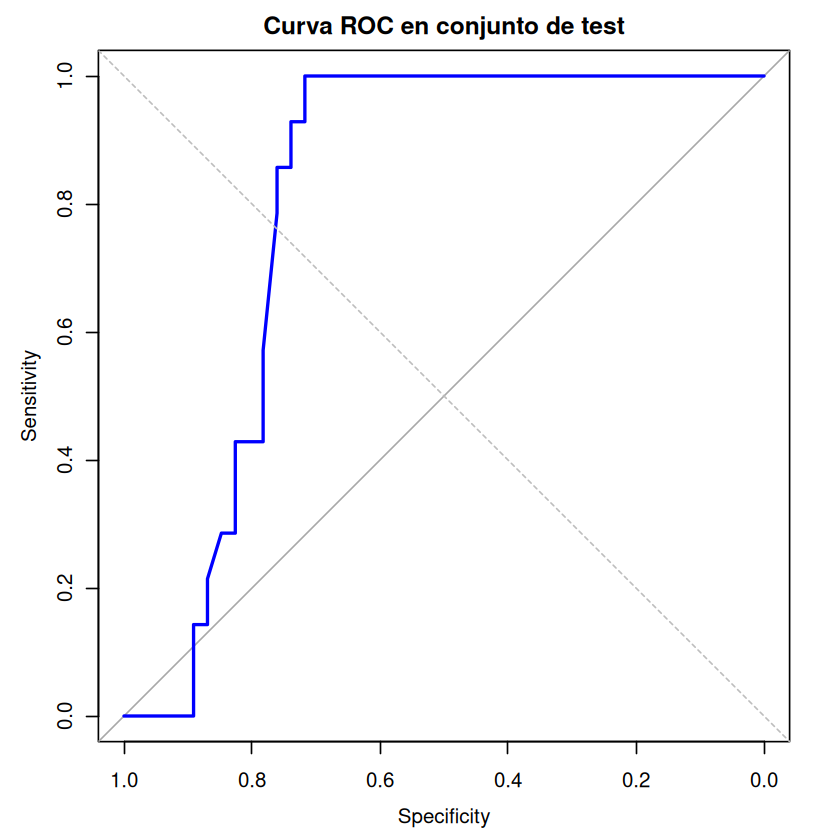

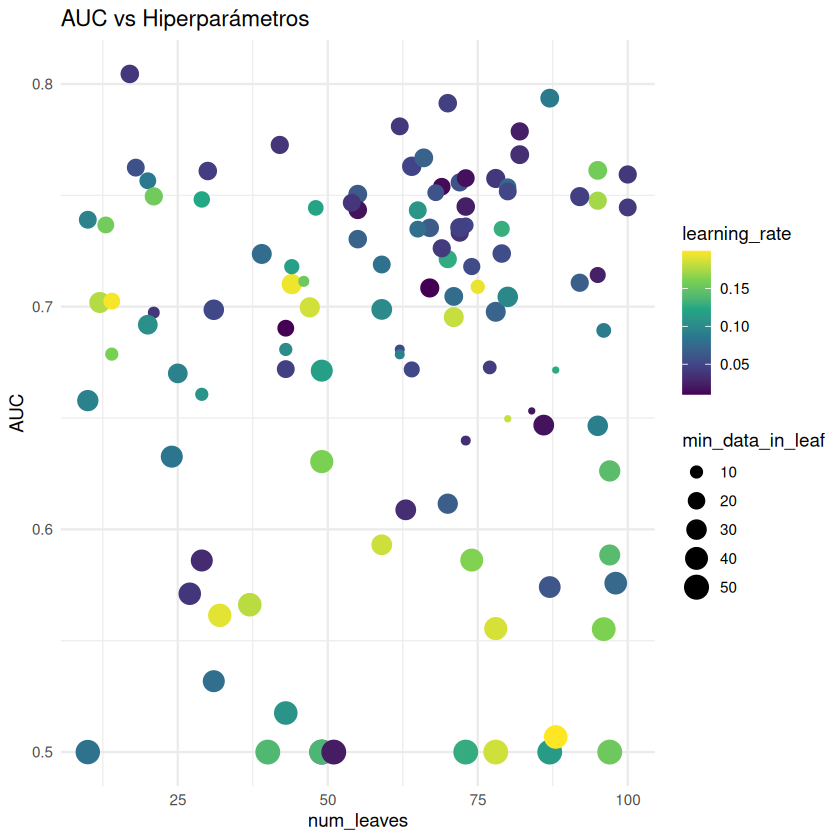

In [30]:
# Paso 14: Entrenamiento final y evaluación en test
# Entrenamos modelo con los mejores hiperparámetros encontrados
dbest <- lgb.train(params = modifyList(param_base, as.list(run$x)),
                   data = dtrain,
                   nrounds = 100)

# Predicciones en el conjunto de test
y_pred <- predict(dbest, data.matrix(test[, !"target", with=FALSE]))

# Cálculo de AUC en test
if (!require("pROC")) install.packages("pROC")
library(pROC)
auc_final <- auc(test$target, y_pred)
cat("AUC en conjunto de test:", auc_final, "
")

# Gráfico de la curva ROC
roc_obj <- roc(test$target, y_pred)
plot(roc_obj, col = "blue", lwd = 2, main = "Curva ROC en conjunto de test")
abline(a = 0, b = 1, lty = 2, col = "gray")

results <- as.data.table(run$opt.path)
ggplot(results, aes(x = num_leaves, y = y)) +
  geom_point(aes(color = learning_rate, size = min_data_in_leaf)) +
  scale_color_viridis_c() +
  labs(title = "AUC vs Hiperparámetros",
       x = "num_leaves",
       y = "AUC",
       color = "learning_rate",
       size = "min_data_in_leaf") +
  theme_minimal()
